# Remaining

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import functional as Flatten
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchsummary import summary

import os, glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import random

import warnings as wrn
wrn.filterwarnings('ignore')

In [ ]:
!unzip '/content/drive/MyDrive/ZSClassification/ZeroShotHandwrittenCharacterRecognition/Bangla/BanglaCharacterDataset.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/Train/201/bcc000060.bmp  
  inflating: Dataset/Train/201/bcc000061.bmp  
  inflating: Dataset/Train/201/bcc000062.bmp  
  inflating: Dataset/Train/201/bcc000063.bmp  
  inflating: Dataset/Train/201/bcc000064.bmp  
  inflating: Dataset/Train/201/bcc000065.bmp  
  inflating: Dataset/Train/201/bcc000066.bmp  
  inflating: Dataset/Train/201/bcc000067.bmp  
  inflating: Dataset/Train/201/bcc000068.bmp  
  inflating: Dataset/Train/201/bcc000069.bmp  
  inflating: Dataset/Train/201/bcc000070.bmp  
  inflating: Dataset/Train/201/bcc000071.bmp  
  inflating: Dataset/Train/201/bcc000072.bmp  
  inflating: Dataset/Train/201/bcc000073.bmp  
  inflating: Dataset/Train/201/bcc000074.bmp  
  inflating: Dataset/Train/201/bcc000075.bmp  
  inflating: Dataset/Train/201/bcc000076.bmp  
  inflating: Dataset/Train/201/bcc000077.bmp  
  inflating: Dataset/Train/201/bcc000078.bmp  
  inflating: Dataset/Train/201/bcc000079.bmp  
  inflati

# After Extraction

In [ ]:
ROOT_DIR = '/content/Dataset'
TRAIN_ROOT = os.path.join(ROOT_DIR, 'Train')
TEST_ROOT = os.path.join(ROOT_DIR, 'Test')
CHECKPOINT = ''

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

IMG_SIZE = (32, 32)
BATCH_SIZE = 32

N_CLASSES = len(os.listdir(TRAIN_ROOT))

In [ ]:
paths = glob.glob('/content/Dataset/*/*/*.bmp')

df = pd.DataFrame({'Path': paths})

def extract_label(path):
    return path.split('/')[-2]

def extract_set(path):
    return path.split('/')[-3]

df['Label'] = df['Path'].apply(extract_label)
df = pd.concat([df, pd.get_dummies(df['Label'])], axis = 1)

df['Set'] = df['Path'].apply(extract_set)

train_df = df.loc[df['Set'] == 'Train'].iloc[:, :-1]
test_df = df.loc[df['Set'] == 'Test'].iloc[:, :-1]

In [ ]:
df

,Path,Label,172,173,174,175,176,177,178,179,...,213,214,215,216,217,218,219,220,221,Set
0,/content/Dataset/Train/195/bcc000050.bmp,195,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Train
1,/content/Dataset/Train/195/bcc000153.bmp,195,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Train
2,/content/Dataset/Train/195/bcc000084.bmp,195,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Train
3,/content/Dataset/Train/195/bcc000013.bmp,195,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Train
4,/content/Dataset/Train/195/bcc000149.bmp,195,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,/content/Dataset/Test/184/bcc000027.bmp,184,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Test
14996,/content/Dataset/Test/184/bcc000010.bmp,184,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Test
14997,/content/Dataset/Test/184/bcc000044.bmp,184,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Test
14998,/content/Dataset/Test/184/bcc000028.bmp,184,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Test


In [ ]:
train_df

,Path,Label,172,173,174,175,176,177,178,179,...,212,213,214,215,216,217,218,219,220,221
0,/content/Dataset/Train/195/bcc000050.bmp,195,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,/content/Dataset/Train/195/bcc000153.bmp,195,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,/content/Dataset/Train/195/bcc000084.bmp,195,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,/content/Dataset/Train/195/bcc000013.bmp,195,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,/content/Dataset/Train/195/bcc000149.bmp,195,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,/content/Dataset/Train/184/bcc000152.bmp,184,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11996,/content/Dataset/Train/184/bcc000057.bmp,184,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11997,/content/Dataset/Train/184/bcc000083.bmp,184,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11998,/content/Dataset/Train/184/bcc000079.bmp,184,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
test_df

,Path,Label,172,173,174,175,176,177,178,179,...,212,213,214,215,216,217,218,219,220,221
12000,/content/Dataset/Test/195/bcc000050.bmp,195,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12001,/content/Dataset/Test/195/bcc000013.bmp,195,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12002,/content/Dataset/Test/195/bcc000021.bmp,195,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12003,/content/Dataset/Test/195/bcc000051.bmp,195,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12004,/content/Dataset/Test/195/bcc000035.bmp,195,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,/content/Dataset/Test/184/bcc000027.bmp,184,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14996,/content/Dataset/Test/184/bcc000010.bmp,184,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14997,/content/Dataset/Test/184/bcc000044.bmp,184,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14998,/content/Dataset/Test/184/bcc000028.bmp,184,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(94, 25, 3)


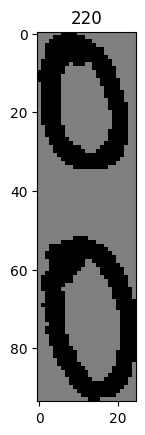

In [ ]:
import matplotlib.pyplot as plt
import random

def imshow():
    idx = random.randint(0, len(train_df))
    img = plt.imread(train_df['Path'][idx])
    label = train_df['Label'][idx]
    print(img.shape)
    plt.imshow(img)
    plt.title(label)
    plt.show()

imshow()

In [ ]:
class CustomDatasetLoader(torch.utils.data.Dataset):

    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.iloc[idx, 0]
        img = cv2.imread(path)

        if self.transform:
            img = self.transform(img)

        label = torch.from_numpy(self.df.iloc[idx, 2:].values.astype(float))

        return (img, label)

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize(IMG_SIZE),
    # torchvision.transforms.Grayscale(num_output_channels=3),
    torchvision.transforms.ToTensor(),
])

train_data = CustomDatasetLoader(df = train_df, transform = transform)
test_data = CustomDatasetLoader(df = test_df, transform = transform)
all_data = CustomDatasetLoader(df = df.iloc[:, :-1], transform = transform)

train_loader = torch.utils.data.DataLoader(
    dataset = train_data, batch_size = 32, shuffle = True, num_workers = 1, drop_last = True
)
test_loader = torch.utils.data.DataLoader(
    dataset = test_data, batch_size = 64, shuffle = True, num_workers = 1, drop_last = False
)
all_data_loader = torch.utils.data.DataLoader(
    dataset = all_data, batch_size = 64, shuffle = True, num_workers = 1, drop_last = False
)

In [ ]:
for (images, labels) in all_data_loader:
    print(images.shape)
    print(labels.shape)
    break

all_data.__len__()

torch.Size([64, 3, 32, 32])
torch.Size([64, 50])


15000

In [ ]:
# class CustomCNN(nn.Module):
#     def __init__(self, n_features=64, dropout=0.1):
#         super(CustomCNN, self).__init__()
#         self.relu = nn.ReLU()
#         self.maxpool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
#         self.conv_dropout = nn.Dropout2d(p=dropout)
#         self.fc_dropout = nn.Dropout(p=dropout)
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), stride=(1, 1), padding=0)
#         self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=0)
#         self.conv3 = nn.Conv2d(in_channels=64, out_channels=96, kernel_size=(3, 3), stride=(1, 1), padding=0)
#         self.conv4 = nn.Conv2d(in_channels=96, out_channels=128, kernel_size=(2, 2), stride=(1, 1), padding=0)
#         self.fc1 = nn.Linear(in_features=128, out_features=128)
#         self.fc2 = nn.Linear(in_features=128, out_features=96)
#         self.out = nn.Linear(in_features=96, out_features=n_features)

#     def forward(self, img):
#         img = self.conv_dropout(self.maxpool(self.relu(self.conv1(img))))
#         img = self.conv_dropout(self.maxpool(self.relu(self.conv2(img))))
#         img = self.conv_dropout(self.maxpool(self.relu(self.conv3(img))))
#         img = self.relu(self.conv4(img))
#         img = img.reshape(img.shape[0], -1)
#         img = self.fc_dropout(self.relu(self.fc1(img)))
#         img = self.fc_dropout(self.relu(self.fc2(img)))
#         img = self.out(img)
#         return img

In [ ]:
class CustomCNN(nn.Module):
    def __init__(self, n_features=64, dropout=0.0):
        super(CustomCNN, self).__init__()
        self.relu = nn.ReLU()
        self.maxpool_k2xs1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(1, 1))
        self.maxpool_k2xs2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv_dropout = nn.Dropout2d(p=dropout)
        self.fc_dropout = nn.Dropout(p=dropout)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(2, 2), stride=(1, 1), padding=0)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), stride=(1, 1), padding=0)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=0)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=0)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(2, 2), stride=(1, 1), padding=0)
        self.fc1 = nn.Linear(in_features=256, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.out = nn.Linear(in_features=64, out_features=n_features)
        self.batch_norm1 = nn.BatchNorm2d(16)
        self.batch_norm2 = nn.BatchNorm2d(32)
        self.batch_norm3 = nn.BatchNorm2d(64)
        self.batch_norm4 = nn.BatchNorm2d(128)
        self.batch_norm5 = nn.BatchNorm2d(256)

    def forward(self, img):
        img = self.conv_dropout(self.batch_norm1(self.maxpool_k2xs1(self.relu(self.conv1(img)))))
        img = self.conv_dropout(self.batch_norm2(self.maxpool_k2xs2(self.relu(self.conv2(img)))))
        img = self.conv_dropout(self.batch_norm3(self.maxpool_k2xs2(self.relu(self.conv3(img)))))
        img = self.conv_dropout(self.batch_norm4(self.maxpool_k2xs2(self.relu(self.conv4(img)))))
        img = self.conv_dropout(self.batch_norm5(self.relu(self.conv5(img))))
        img = img.reshape(img.shape[0], -1)
        img = self.fc_dropout(self.relu(self.fc1(img)))
        img = self.fc_dropout(self.relu(self.fc2(img)))
        img = self.out(img)
        return img

In [ ]:
model = CustomCNN(n_features=64).to(DEVICE)
sum(p.numel() for p in model.parameters() if p.requires_grad)

274832

In [ ]:
# model = CustomCNN(n_features=64).to(DEVICE)
# model

In [ ]:
from torchsummary import summary

summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 31, 31]             208
              ReLU-2           [-1, 16, 31, 31]               0
         MaxPool2d-3           [-1, 16, 30, 30]               0
       BatchNorm2d-4           [-1, 16, 30, 30]              32
         Dropout2d-5           [-1, 16, 30, 30]               0
            Conv2d-6           [-1, 32, 28, 28]           4,640
              ReLU-7           [-1, 32, 28, 28]               0
         MaxPool2d-8           [-1, 32, 14, 14]               0
       BatchNorm2d-9           [-1, 32, 14, 14]              64
        Dropout2d-10           [-1, 32, 14, 14]               0
           Conv2d-11           [-1, 64, 12, 12]          18,496
             ReLU-12           [-1, 64, 12, 12]               0
        MaxPool2d-13             [-1, 64, 6, 6]               0
      BatchNorm2d-14             [-1, 6

In [ ]:
# for (images, labels) in tqdm(train_loader):
#     images, labels = images.to(DEVICE), labels.to(DEVICE)
#     predictions = model(images)
#     print(predictions.shape, labels.shape)
#     # predictions = torch.matmul(predictions.to(float), embedding)
#     # print(predictions.shape, labels.shape)
#     break

In [ ]:
def train(model, dataloader, embedding, criterion, optimizer, device):
    model.train()

    train_count, correct_predictions, train_loss = 0, 0, 0

    for (images, labels) in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)

        # _, labels = torch.max(labels.data, 1)

        predictions = model(images)
        predictions = torch.matmul(predictions.to(float), embedding)

        optimizer.zero_grad()
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()

        _, predictions = torch.max(predictions.data, 1)
        _, labels = torch.max(labels.data, 1)

        train_count += labels.shape[0]
        correct_predictions += (predictions == labels).sum().item()
        train_loss += loss.item()

    train_acc = correct_predictions / train_count
    train_loss = train_loss / len(train_loader)

    return train_acc, train_loss

In [ ]:
def test(model, dataloader, embedding, device):
    model.eval()
    test_count, correct_predictions = 0, 0

    with torch.no_grad():
        for (images, labels) in tqdm(dataloader):
            images, labels = images.to(device), labels.to(device)

            predictions = model(images)
            predictions = torch.matmul(predictions.to(float), embedding)

            _, predictions = torch.max(predictions.data, 1)
            _, labels = torch.max(labels.data, 1)

            test_count += labels.shape[0]
            correct_predictions += (predictions == labels).sum().item()

        test_acc = correct_predictions / test_count

    return test_acc

# embd_all_images_avg_df

In [ ]:
model = CustomCNN(n_features=64).to(DEVICE)
sum(p.numel() for p in model.parameters() if p.requires_grad)

274832

In [ ]:
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
embedding = pd.read_csv('/content/drive/MyDrive/ZSClassification/ZeroShotHandwrittenCharacterRecognition/Bangla/Embd_VAEResnet/embd_all_images_avg_df.csv')

embedding = embedding.iloc[:, :].values
# embedding = embedding.iloc[:, :].values.T
embedding = torch.from_numpy(embedding)
embedding = embedding.to(DEVICE)
embedding.shape, embedding

(torch.Size([64, 50]),
 tensor([[ 1.1641, -0.2061,  1.3992,  ...,  0.8768,  0.4459,  0.2451],
         [-3.2741, -2.2443,  0.4083,  ..., -0.1000,  1.1276,  1.1679],
         [ 0.1050, -0.4292, -0.6428,  ..., -0.7162, -0.3833, -0.4157],
         ...,
         [ 0.0384,  0.9029,  1.6905,  ..., -0.7060,  1.6201,  1.0158],
         [-0.4106, -1.2564,  0.5205,  ...,  0.1386,  2.7253,  1.1343],
         [-0.1621, -0.3537,  0.6516,  ...,  0.5294, -0.2913, -0.0707]],
        device='cuda:0', dtype=torch.float64))

In [ ]:
best_loss, best_acc = 1e10, 0

for epoch in range(50+1):
    print(f"Epoch: {epoch}")

    # if os.path.exists('model.pth'):
    #     model.load_state_dict(torch.load('model.pth'))

    train_acc, train_loss = train(model, train_loader, embedding, criterion, optimizer, DEVICE)
    test_acc = test(model, test_loader, embedding, DEVICE)
    print(f"Training Accuracy: {train_acc*100:.3f}%, Training Loss: {train_loss:.4f}, Test Accuracy: {test_acc*100:.3f}%\n")

    # if epoch % 5 == 0 and test_acc > best_acc and train_loss < best_loss:
    if train_loss < best_loss:
        best_acc = test_acc
        best_loss = train_loss
        torch.save(model.state_dict(), "model.pth")
        print(f"{'-'*20}\nModel Saved\n{'-'*20}")

Epoch: 0


100%|██████████| 47/47 [00:02<00:00, 21.39it/s]


Training Accuracy: 58.867%, Training Loss: 1.3954, Test Accuracy: 75.500%

--------------------
Model Saved
--------------------
Epoch: 1


100%|██████████| 47/47 [00:02<00:00, 21.01it/s]


Training Accuracy: 81.792%, Training Loss: 0.5947, Test Accuracy: 84.033%

--------------------
Model Saved
--------------------
Epoch: 2


100%|██████████| 47/47 [00:02<00:00, 21.33it/s]


Training Accuracy: 87.775%, Training Loss: 0.3933, Test Accuracy: 88.733%

--------------------
Model Saved
--------------------
Epoch: 3


100%|██████████| 47/47 [00:02<00:00, 18.19it/s]


Training Accuracy: 90.517%, Training Loss: 0.2980, Test Accuracy: 90.633%

--------------------
Model Saved
--------------------
Epoch: 4


100%|██████████| 47/47 [00:03<00:00, 11.91it/s]


Training Accuracy: 91.842%, Training Loss: 0.2468, Test Accuracy: 89.800%

--------------------
Model Saved
--------------------
Epoch: 5


100%|██████████| 47/47 [00:02<00:00, 17.42it/s]


Training Accuracy: 92.975%, Training Loss: 0.2190, Test Accuracy: 87.733%

--------------------
Model Saved
--------------------
Epoch: 6


100%|██████████| 47/47 [00:02<00:00, 20.96it/s]


Training Accuracy: 93.908%, Training Loss: 0.1903, Test Accuracy: 88.333%

--------------------
Model Saved
--------------------
Epoch: 7


100%|██████████| 47/47 [00:02<00:00, 21.54it/s]


Training Accuracy: 94.733%, Training Loss: 0.1576, Test Accuracy: 91.033%

--------------------
Model Saved
--------------------
Epoch: 8


100%|██████████| 47/47 [00:02<00:00, 21.49it/s]


Training Accuracy: 95.025%, Training Loss: 0.1638, Test Accuracy: 91.467%

Epoch: 9


100%|██████████| 47/47 [00:02<00:00, 21.10it/s]


Training Accuracy: 95.783%, Training Loss: 0.1300, Test Accuracy: 91.533%

--------------------
Model Saved
--------------------
Epoch: 10


100%|██████████| 47/47 [00:02<00:00, 21.07it/s]


Training Accuracy: 96.408%, Training Loss: 0.1150, Test Accuracy: 91.833%

--------------------
Model Saved
--------------------
Epoch: 11


100%|██████████| 47/47 [00:02<00:00, 21.49it/s]


Training Accuracy: 96.008%, Training Loss: 0.1270, Test Accuracy: 90.600%

Epoch: 12


100%|██████████| 47/47 [00:02<00:00, 21.37it/s]


Training Accuracy: 95.975%, Training Loss: 0.1359, Test Accuracy: 91.000%

Epoch: 13


100%|██████████| 47/47 [00:02<00:00, 20.04it/s]


Training Accuracy: 96.742%, Training Loss: 0.1010, Test Accuracy: 93.100%

--------------------
Model Saved
--------------------
Epoch: 14


100%|██████████| 47/47 [00:02<00:00, 16.09it/s]


Training Accuracy: 97.517%, Training Loss: 0.0803, Test Accuracy: 92.467%

--------------------
Model Saved
--------------------
Epoch: 15


100%|██████████| 47/47 [00:02<00:00, 15.93it/s]


Training Accuracy: 96.508%, Training Loss: 0.1227, Test Accuracy: 92.267%

Epoch: 16


100%|██████████| 47/47 [00:02<00:00, 18.21it/s]


Training Accuracy: 97.150%, Training Loss: 0.0931, Test Accuracy: 93.400%

Epoch: 17


100%|██████████| 47/47 [00:02<00:00, 21.05it/s]


Training Accuracy: 97.550%, Training Loss: 0.0811, Test Accuracy: 93.733%

Epoch: 18


100%|██████████| 47/47 [00:02<00:00, 21.24it/s]


Training Accuracy: 97.617%, Training Loss: 0.0866, Test Accuracy: 91.433%

Epoch: 19


100%|██████████| 47/47 [00:02<00:00, 21.24it/s]


Training Accuracy: 97.133%, Training Loss: 0.0995, Test Accuracy: 93.933%

Epoch: 20


100%|██████████| 47/47 [00:02<00:00, 21.03it/s]


Training Accuracy: 97.908%, Training Loss: 0.0704, Test Accuracy: 93.400%

--------------------
Model Saved
--------------------
Epoch: 21


100%|██████████| 47/47 [00:02<00:00, 21.12it/s]


Training Accuracy: 97.300%, Training Loss: 0.0896, Test Accuracy: 93.267%

Epoch: 22


100%|██████████| 47/47 [00:02<00:00, 21.20it/s]


Training Accuracy: 97.767%, Training Loss: 0.0819, Test Accuracy: 92.867%

Epoch: 23


100%|██████████| 47/47 [00:02<00:00, 20.97it/s]


Training Accuracy: 98.367%, Training Loss: 0.0539, Test Accuracy: 92.300%

--------------------
Model Saved
--------------------
Epoch: 24


100%|██████████| 47/47 [00:02<00:00, 21.39it/s]


Training Accuracy: 97.900%, Training Loss: 0.0724, Test Accuracy: 93.800%

Epoch: 25


100%|██████████| 47/47 [00:02<00:00, 20.81it/s]


Training Accuracy: 98.167%, Training Loss: 0.0642, Test Accuracy: 93.200%

Epoch: 26


100%|██████████| 47/47 [00:02<00:00, 20.63it/s]


Training Accuracy: 98.092%, Training Loss: 0.0625, Test Accuracy: 93.467%

Epoch: 27


100%|██████████| 47/47 [00:02<00:00, 17.24it/s]


Training Accuracy: 98.067%, Training Loss: 0.0709, Test Accuracy: 93.000%

Epoch: 28


100%|██████████| 47/47 [00:03<00:00, 15.01it/s]


Training Accuracy: 98.325%, Training Loss: 0.0600, Test Accuracy: 92.333%

Epoch: 29


100%|██████████| 47/47 [00:02<00:00, 16.50it/s]


Training Accuracy: 98.250%, Training Loss: 0.0607, Test Accuracy: 93.200%

Epoch: 30


100%|██████████| 47/47 [00:02<00:00, 21.35it/s]


Training Accuracy: 98.775%, Training Loss: 0.0448, Test Accuracy: 93.633%

--------------------
Model Saved
--------------------
Epoch: 31


100%|██████████| 47/47 [00:02<00:00, 23.06it/s]


Training Accuracy: 98.592%, Training Loss: 0.0466, Test Accuracy: 92.900%

Epoch: 32


100%|██████████| 47/47 [00:02<00:00, 22.70it/s]


Training Accuracy: 97.942%, Training Loss: 0.0714, Test Accuracy: 93.167%

Epoch: 33


100%|██████████| 47/47 [00:02<00:00, 23.00it/s]


Training Accuracy: 98.542%, Training Loss: 0.0509, Test Accuracy: 94.300%

Epoch: 34


100%|██████████| 47/47 [00:02<00:00, 23.18it/s]


Training Accuracy: 98.150%, Training Loss: 0.0702, Test Accuracy: 93.767%

Epoch: 35


100%|██████████| 47/47 [00:02<00:00, 22.75it/s]


Training Accuracy: 98.542%, Training Loss: 0.0581, Test Accuracy: 94.033%

Epoch: 36


100%|██████████| 47/47 [00:02<00:00, 22.31it/s]


Training Accuracy: 98.833%, Training Loss: 0.0403, Test Accuracy: 93.400%

--------------------
Model Saved
--------------------
Epoch: 37


100%|██████████| 47/47 [00:02<00:00, 17.40it/s]


Training Accuracy: 98.475%, Training Loss: 0.0613, Test Accuracy: 93.800%

Epoch: 38


100%|██████████| 47/47 [00:02<00:00, 17.66it/s]


Training Accuracy: 98.950%, Training Loss: 0.0411, Test Accuracy: 93.400%

Epoch: 39


100%|██████████| 47/47 [00:02<00:00, 23.17it/s]


Training Accuracy: 98.792%, Training Loss: 0.0380, Test Accuracy: 94.000%

--------------------
Model Saved
--------------------
Epoch: 40


100%|██████████| 47/47 [00:02<00:00, 22.31it/s]


Training Accuracy: 98.858%, Training Loss: 0.0419, Test Accuracy: 94.400%

Epoch: 41


100%|██████████| 47/47 [00:02<00:00, 23.08it/s]


Training Accuracy: 98.758%, Training Loss: 0.0445, Test Accuracy: 93.567%

Epoch: 42


100%|██████████| 47/47 [00:02<00:00, 22.85it/s]


Training Accuracy: 98.125%, Training Loss: 0.0709, Test Accuracy: 93.800%

Epoch: 43


100%|██████████| 47/47 [00:02<00:00, 22.86it/s]


Training Accuracy: 98.950%, Training Loss: 0.0371, Test Accuracy: 94.400%

--------------------
Model Saved
--------------------
Epoch: 44


100%|██████████| 47/47 [00:02<00:00, 22.84it/s]


Training Accuracy: 98.867%, Training Loss: 0.0413, Test Accuracy: 93.467%

Epoch: 45


100%|██████████| 47/47 [00:02<00:00, 21.32it/s]


Training Accuracy: 98.683%, Training Loss: 0.0496, Test Accuracy: 93.967%

Epoch: 46


100%|██████████| 47/47 [00:02<00:00, 17.47it/s]


Training Accuracy: 98.925%, Training Loss: 0.0387, Test Accuracy: 90.833%

Epoch: 47


100%|██████████| 47/47 [00:02<00:00, 16.33it/s]


Training Accuracy: 98.642%, Training Loss: 0.0523, Test Accuracy: 94.233%

Epoch: 48


100%|██████████| 47/47 [00:02<00:00, 20.33it/s]


Training Accuracy: 98.992%, Training Loss: 0.0337, Test Accuracy: 94.600%

--------------------
Model Saved
--------------------
Epoch: 49


100%|██████████| 47/47 [00:02<00:00, 23.26it/s]


Training Accuracy: 99.183%, Training Loss: 0.0324, Test Accuracy: 93.967%

--------------------
Model Saved
--------------------
Epoch: 50


100%|██████████| 47/47 [00:02<00:00, 22.98it/s]

Training Accuracy: 99.342%, Training Loss: 0.0216, Test Accuracy: 94.433%

--------------------
Model Saved
--------------------


In [ ]:
if os.path.exists('model.pth'):
    model.load_state_dict(torch.load('model.pth'))

test_acc = test(model, test_loader, embedding, DEVICE)
print(f"Test Accuracy: {test_acc*100:.3f}%\n")

100%|██████████| 47/47 [00:02<00:00, 23.22it/s]

Test Accuracy: 94.433%



# embd_all_images

In [ ]:
model = CustomCNN(n_features=64).to(DEVICE)
sum(p.numel() for p in model.parameters() if p.requires_grad)

274832

In [ ]:
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
embedding = pd.read_csv('/content/drive/MyDrive/ZSClassification/ZeroShotHandwrittenCharacterRecognition/Bangla/Embd_VAEResnet/embd_all_images.csv')

embedding = embedding.iloc[:, :].values
# embedding = embedding.iloc[:, :].values.T
embedding = torch.from_numpy(embedding)
embedding = embedding.to(DEVICE)
embedding.shape, embedding

(torch.Size([64, 50]),
 tensor([[ 349.2411,  -61.8338,  419.7692,  ...,  263.0367,  133.7644,
            73.5246],
         [-982.2263, -673.3030,  122.4967,  ...,  -30.0119,  338.2677,
           350.3825],
         [  31.5089, -128.7522, -192.8413,  ..., -214.8663, -114.9991,
          -124.7092],
         ...,
         [  11.5285,  270.8819,  507.1630,  ..., -211.8138,  486.0310,
           304.7363],
         [-123.1875, -376.9318,  156.1647,  ...,   41.5758,  817.5924,
           340.2778],
         [ -48.6206, -106.1077,  195.4945,  ...,  158.8239,  -87.3832,
           -21.2089]], device='cuda:0', dtype=torch.float64))

In [ ]:
best_loss, best_acc = 1e10, 0

for epoch in range(50+1):
    print(f"Epoch: {epoch}")

    # if os.path.exists('model.pth'):
    #     model.load_state_dict(torch.load('model.pth'))

    train_acc, train_loss = train(model, train_loader, embedding, criterion, optimizer, DEVICE)
    test_acc = test(model, test_loader, embedding, DEVICE)
    print(f"Training Accuracy: {train_acc*100:.3f}%, Training Loss: {train_loss:.4f}, Test Accuracy: {test_acc*100:.3f}%\n")

    # if epoch % 5 == 0 and test_acc > best_acc and train_loss < best_loss:
    if train_loss < best_loss:
        best_acc = test_acc
        best_loss = train_loss
        torch.save(model.state_dict(), "model.pth")
        print(f"{'-'*20}\nModel Saved\n{'-'*20}")

Epoch: 0


100%|██████████| 47/47 [00:02<00:00, 23.44it/s]


Training Accuracy: 23.225%, Training Loss: 37.7415, Test Accuracy: 25.000%

--------------------
Model Saved
--------------------
Epoch: 1


100%|██████████| 47/47 [00:02<00:00, 21.78it/s]


Training Accuracy: 32.558%, Training Loss: 4.8238, Test Accuracy: 36.067%

--------------------
Model Saved
--------------------
Epoch: 2


100%|██████████| 47/47 [00:02<00:00, 23.36it/s]


Training Accuracy: 40.108%, Training Loss: 3.5884, Test Accuracy: 44.100%

--------------------
Model Saved
--------------------
Epoch: 3


100%|██████████| 47/47 [00:02<00:00, 23.46it/s]


Training Accuracy: 46.533%, Training Loss: 2.7706, Test Accuracy: 48.800%

--------------------
Model Saved
--------------------
Epoch: 4


100%|██████████| 47/47 [00:02<00:00, 23.18it/s]


Training Accuracy: 52.017%, Training Loss: 2.4781, Test Accuracy: 54.500%

--------------------
Model Saved
--------------------
Epoch: 5


100%|██████████| 47/47 [00:02<00:00, 20.21it/s]


Training Accuracy: 56.175%, Training Loss: 2.2235, Test Accuracy: 52.367%

--------------------
Model Saved
--------------------
Epoch: 6


100%|██████████| 47/47 [00:02<00:00, 16.12it/s]


Training Accuracy: 57.917%, Training Loss: 2.2310, Test Accuracy: 53.167%

Epoch: 7


100%|██████████| 47/47 [00:02<00:00, 19.06it/s]


Training Accuracy: 60.183%, Training Loss: 2.0793, Test Accuracy: 58.367%

--------------------
Model Saved
--------------------
Epoch: 8


100%|██████████| 47/47 [00:02<00:00, 23.35it/s]


Training Accuracy: 60.333%, Training Loss: 2.1576, Test Accuracy: 63.067%

Epoch: 9


100%|██████████| 47/47 [00:02<00:00, 23.06it/s]


Training Accuracy: 62.050%, Training Loss: 1.9322, Test Accuracy: 61.733%

--------------------
Model Saved
--------------------
Epoch: 10


100%|██████████| 47/47 [00:02<00:00, 23.11it/s]


Training Accuracy: 64.242%, Training Loss: 1.9101, Test Accuracy: 62.100%

--------------------
Model Saved
--------------------
Epoch: 11


100%|██████████| 47/47 [00:02<00:00, 22.51it/s]


Training Accuracy: 66.158%, Training Loss: 1.7635, Test Accuracy: 65.767%

--------------------
Model Saved
--------------------
Epoch: 12


100%|██████████| 47/47 [00:02<00:00, 22.75it/s]


Training Accuracy: 64.000%, Training Loss: 2.0658, Test Accuracy: 62.800%

Epoch: 13


100%|██████████| 47/47 [00:02<00:00, 23.13it/s]


Training Accuracy: 68.825%, Training Loss: 1.6176, Test Accuracy: 67.500%

--------------------
Model Saved
--------------------
Epoch: 14


100%|██████████| 47/47 [00:02<00:00, 17.19it/s]


Training Accuracy: 69.892%, Training Loss: 1.6987, Test Accuracy: 73.667%

Epoch: 15


100%|██████████| 47/47 [00:02<00:00, 17.75it/s]


Training Accuracy: 72.417%, Training Loss: 1.4204, Test Accuracy: 74.733%

--------------------
Model Saved
--------------------
Epoch: 16


100%|██████████| 47/47 [00:01<00:00, 23.59it/s]


Training Accuracy: 73.367%, Training Loss: 1.4427, Test Accuracy: 76.367%

Epoch: 17


100%|██████████| 47/47 [00:02<00:00, 23.27it/s]


Training Accuracy: 71.242%, Training Loss: 1.6032, Test Accuracy: 64.133%

Epoch: 18


100%|██████████| 47/47 [00:02<00:00, 23.08it/s]


Training Accuracy: 72.583%, Training Loss: 1.4757, Test Accuracy: 71.067%

Epoch: 19


100%|██████████| 47/47 [00:01<00:00, 23.56it/s]


Training Accuracy: 75.700%, Training Loss: 1.2916, Test Accuracy: 76.267%

--------------------
Model Saved
--------------------
Epoch: 20


100%|██████████| 47/47 [00:02<00:00, 23.35it/s]


Training Accuracy: 78.792%, Training Loss: 1.1552, Test Accuracy: 72.500%

--------------------
Model Saved
--------------------
Epoch: 21


100%|██████████| 47/47 [00:02<00:00, 23.14it/s]


Training Accuracy: 74.542%, Training Loss: 1.5143, Test Accuracy: 70.433%

Epoch: 22


100%|██████████| 47/47 [00:02<00:00, 19.73it/s]


Training Accuracy: 78.083%, Training Loss: 1.3123, Test Accuracy: 77.100%

Epoch: 23


100%|██████████| 47/47 [00:02<00:00, 16.75it/s]


Training Accuracy: 77.183%, Training Loss: 1.3369, Test Accuracy: 78.600%

Epoch: 24


100%|██████████| 47/47 [00:02<00:00, 20.57it/s]


Training Accuracy: 80.683%, Training Loss: 1.0780, Test Accuracy: 78.400%

--------------------
Model Saved
--------------------
Epoch: 25


100%|██████████| 47/47 [00:01<00:00, 23.56it/s]


Training Accuracy: 81.333%, Training Loss: 1.0628, Test Accuracy: 79.100%

--------------------
Model Saved
--------------------
Epoch: 26


100%|██████████| 47/47 [00:01<00:00, 23.57it/s]


Training Accuracy: 79.733%, Training Loss: 1.2382, Test Accuracy: 77.500%

Epoch: 27


100%|██████████| 47/47 [00:02<00:00, 22.81it/s]


Training Accuracy: 81.825%, Training Loss: 1.0695, Test Accuracy: 80.167%

Epoch: 28


100%|██████████| 47/47 [00:02<00:00, 23.02it/s]


Training Accuracy: 80.500%, Training Loss: 1.2876, Test Accuracy: 82.000%

Epoch: 29


100%|██████████| 47/47 [00:02<00:00, 22.69it/s]


Training Accuracy: 82.317%, Training Loss: 1.2558, Test Accuracy: 79.567%

Epoch: 30


100%|██████████| 47/47 [00:02<00:00, 21.60it/s]


Training Accuracy: 83.408%, Training Loss: 1.0047, Test Accuracy: 80.033%

--------------------
Model Saved
--------------------
Epoch: 31


100%|██████████| 47/47 [00:02<00:00, 16.76it/s]


Training Accuracy: 84.575%, Training Loss: 0.9811, Test Accuracy: 82.733%

--------------------
Model Saved
--------------------
Epoch: 32


100%|██████████| 47/47 [00:02<00:00, 18.42it/s]


Training Accuracy: 85.267%, Training Loss: 0.9255, Test Accuracy: 81.967%

--------------------
Model Saved
--------------------
Epoch: 33


100%|██████████| 47/47 [00:02<00:00, 22.94it/s]


Training Accuracy: 82.567%, Training Loss: 1.1854, Test Accuracy: 79.133%

Epoch: 34


100%|██████████| 47/47 [00:02<00:00, 22.46it/s]


Training Accuracy: 80.692%, Training Loss: 1.3591, Test Accuracy: 74.033%

Epoch: 35


100%|██████████| 47/47 [00:02<00:00, 22.80it/s]


Training Accuracy: 80.042%, Training Loss: 1.4769, Test Accuracy: 80.500%

Epoch: 36


100%|██████████| 47/47 [00:02<00:00, 23.45it/s]


Training Accuracy: 83.925%, Training Loss: 0.9851, Test Accuracy: 80.467%

Epoch: 37


100%|██████████| 47/47 [00:02<00:00, 22.72it/s]


Training Accuracy: 86.642%, Training Loss: 0.8439, Test Accuracy: 86.300%

--------------------
Model Saved
--------------------
Epoch: 38


100%|██████████| 47/47 [00:02<00:00, 21.74it/s]


Training Accuracy: 87.717%, Training Loss: 0.8091, Test Accuracy: 84.767%

--------------------
Model Saved
--------------------
Epoch: 39


100%|██████████| 47/47 [00:02<00:00, 21.78it/s]


Training Accuracy: 84.925%, Training Loss: 0.9892, Test Accuracy: 81.833%

Epoch: 40


100%|██████████| 47/47 [00:02<00:00, 17.29it/s]


Training Accuracy: 86.100%, Training Loss: 0.9343, Test Accuracy: 82.933%

Epoch: 41


100%|██████████| 47/47 [00:02<00:00, 16.82it/s]


Training Accuracy: 85.992%, Training Loss: 1.0885, Test Accuracy: 82.900%

Epoch: 42


100%|██████████| 47/47 [00:02<00:00, 21.58it/s]


Training Accuracy: 86.075%, Training Loss: 0.9733, Test Accuracy: 84.867%

Epoch: 43


100%|██████████| 47/47 [00:02<00:00, 23.11it/s]


Training Accuracy: 86.642%, Training Loss: 0.9598, Test Accuracy: 82.600%

Epoch: 44


100%|██████████| 47/47 [00:02<00:00, 22.74it/s]


Training Accuracy: 84.767%, Training Loss: 1.1500, Test Accuracy: 83.800%

Epoch: 45


100%|██████████| 47/47 [00:02<00:00, 23.10it/s]


Training Accuracy: 87.058%, Training Loss: 0.8337, Test Accuracy: 82.267%

Epoch: 46


100%|██████████| 47/47 [00:02<00:00, 22.78it/s]


Training Accuracy: 86.308%, Training Loss: 0.8960, Test Accuracy: 80.233%

Epoch: 47


100%|██████████| 47/47 [00:02<00:00, 22.37it/s]


Training Accuracy: 81.992%, Training Loss: 1.2337, Test Accuracy: 79.233%

Epoch: 48


100%|██████████| 47/47 [00:02<00:00, 21.53it/s]


Training Accuracy: 88.358%, Training Loss: 0.6736, Test Accuracy: 84.100%

--------------------
Model Saved
--------------------
Epoch: 49


100%|██████████| 47/47 [00:02<00:00, 16.50it/s]


Training Accuracy: 89.408%, Training Loss: 0.7142, Test Accuracy: 83.633%

Epoch: 50


100%|██████████| 47/47 [00:02<00:00, 17.59it/s]

Training Accuracy: 89.067%, Training Loss: 0.8678, Test Accuracy: 86.533%



In [ ]:
if os.path.exists('model.pth'):
    model.load_state_dict(torch.load('model.pth'))

test_acc = test(model, test_loader, embedding, DEVICE)
print(f"Test Accuracy: {test_acc*100:.3f}%\n")

100%|██████████| 47/47 [00:02<00:00, 18.99it/s]

Test Accuracy: 84.100%



# embd_random1

In [ ]:
model = CustomCNN(n_features=64).to(DEVICE)
sum(p.numel() for p in model.parameters() if p.requires_grad)

274832

In [ ]:
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
embedding = pd.read_csv('/content/drive/MyDrive/ZSClassification/ZeroShotHandwrittenCharacterRecognition/Bangla/Embd_VAEResnet/embd_random1.csv')

embedding = embedding.iloc[:, :].values
# embedding = embedding.iloc[:, :].values.T
embedding = torch.from_numpy(embedding)
embedding = embedding.to(DEVICE)
embedding.shape, embedding

(torch.Size([64, 50]),
 tensor([[ 3.9244,  0.3440,  2.4765,  ...,  2.6769,  1.0539,  0.4869],
         [-3.8767, -0.9664, -0.5295,  ...,  0.9155,  1.8477, -0.1087],
         [-0.3250, -0.6472, -2.2057,  ..., -2.9427, -1.3208, -0.0983],
         ...,
         [-1.0548,  6.8298,  2.3564,  ..., -0.9042,  2.7647, -2.0331],
         [-1.1054,  0.3436, -1.8729,  ..., -1.3144,  3.4403,  0.9998],
         [ 2.6528, -1.1657,  0.5382,  ...,  1.2612,  0.1995,  1.2509]],
        device='cuda:0', dtype=torch.float64))

In [ ]:
best_loss, best_acc = 1e10, 0

for epoch in range(50+1):
    print(f"Epoch: {epoch}")

    # if os.path.exists('model.pth'):
    #     model.load_state_dict(torch.load('model.pth'))

    train_acc, train_loss = train(model, train_loader, embedding, criterion, optimizer, DEVICE)
    test_acc = test(model, test_loader, embedding, DEVICE)
    print(f"Training Accuracy: {train_acc*100:.3f}%, Training Loss: {train_loss:.4f}, Test Accuracy: {test_acc*100:.3f}%\n")

    # if epoch % 5 == 0 and test_acc > best_acc and train_loss < best_loss:
    if train_loss < best_loss:
        best_acc = test_acc
        best_loss = train_loss
        torch.save(model.state_dict(), "model.pth")
        print(f"{'-'*20}\nModel Saved\n{'-'*20}")

Epoch: 0


100%|██████████| 47/47 [00:02<00:00, 18.04it/s]


Training Accuracy: 50.858%, Training Loss: 1.8089, Test Accuracy: 75.933%

--------------------
Model Saved
--------------------
Epoch: 1


100%|██████████| 47/47 [00:02<00:00, 15.91it/s]


Training Accuracy: 78.892%, Training Loss: 0.7116, Test Accuracy: 84.533%

--------------------
Model Saved
--------------------
Epoch: 2


100%|██████████| 47/47 [00:02<00:00, 20.61it/s]


Training Accuracy: 86.725%, Training Loss: 0.4532, Test Accuracy: 85.200%

--------------------
Model Saved
--------------------
Epoch: 3


100%|██████████| 47/47 [00:02<00:00, 23.37it/s]


Training Accuracy: 89.867%, Training Loss: 0.3272, Test Accuracy: 85.967%

--------------------
Model Saved
--------------------
Epoch: 4


100%|██████████| 47/47 [00:02<00:00, 22.96it/s]


Training Accuracy: 90.817%, Training Loss: 0.3007, Test Accuracy: 88.233%

--------------------
Model Saved
--------------------
Epoch: 5


100%|██████████| 47/47 [00:02<00:00, 23.12it/s]


Training Accuracy: 92.992%, Training Loss: 0.2318, Test Accuracy: 89.600%

--------------------
Model Saved
--------------------
Epoch: 6


100%|██████████| 47/47 [00:02<00:00, 22.31it/s]


Training Accuracy: 93.425%, Training Loss: 0.2087, Test Accuracy: 90.333%

--------------------
Model Saved
--------------------
Epoch: 7


100%|██████████| 47/47 [00:02<00:00, 23.07it/s]


Training Accuracy: 93.917%, Training Loss: 0.1963, Test Accuracy: 89.767%

--------------------
Model Saved
--------------------
Epoch: 8


100%|██████████| 47/47 [00:02<00:00, 23.11it/s]


Training Accuracy: 94.558%, Training Loss: 0.1762, Test Accuracy: 90.533%

--------------------
Model Saved
--------------------
Epoch: 9


100%|██████████| 47/47 [00:02<00:00, 18.83it/s]


Training Accuracy: 94.933%, Training Loss: 0.1712, Test Accuracy: 91.000%

--------------------
Model Saved
--------------------
Epoch: 10


100%|██████████| 47/47 [00:02<00:00, 16.07it/s]


Training Accuracy: 95.708%, Training Loss: 0.1449, Test Accuracy: 90.300%

--------------------
Model Saved
--------------------
Epoch: 11


100%|██████████| 47/47 [00:02<00:00, 17.80it/s]


Training Accuracy: 95.108%, Training Loss: 0.1578, Test Accuracy: 90.500%

Epoch: 12


100%|██████████| 47/47 [00:02<00:00, 21.78it/s]


Training Accuracy: 96.375%, Training Loss: 0.1156, Test Accuracy: 91.333%

--------------------
Model Saved
--------------------
Epoch: 13


100%|██████████| 47/47 [00:02<00:00, 22.91it/s]


Training Accuracy: 96.325%, Training Loss: 0.1240, Test Accuracy: 91.267%

Epoch: 14


100%|██████████| 47/47 [00:02<00:00, 22.18it/s]


Training Accuracy: 95.775%, Training Loss: 0.1602, Test Accuracy: 91.033%

Epoch: 15


100%|██████████| 47/47 [00:02<00:00, 22.37it/s]


Training Accuracy: 96.692%, Training Loss: 0.1170, Test Accuracy: 91.167%

Epoch: 16


100%|██████████| 47/47 [00:02<00:00, 22.53it/s]


Training Accuracy: 97.925%, Training Loss: 0.0759, Test Accuracy: 91.867%

--------------------
Model Saved
--------------------
Epoch: 17


100%|██████████| 47/47 [00:02<00:00, 22.67it/s]


Training Accuracy: 97.200%, Training Loss: 0.0996, Test Accuracy: 92.567%

Epoch: 18


100%|██████████| 47/47 [00:02<00:00, 22.82it/s]


Training Accuracy: 96.683%, Training Loss: 0.1184, Test Accuracy: 92.400%

Epoch: 19


100%|██████████| 47/47 [00:02<00:00, 21.99it/s]


Training Accuracy: 97.242%, Training Loss: 0.1006, Test Accuracy: 91.433%

Epoch: 20


100%|██████████| 47/47 [00:02<00:00, 17.73it/s]


Training Accuracy: 96.942%, Training Loss: 0.1071, Test Accuracy: 92.100%

Epoch: 21


100%|██████████| 47/47 [00:02<00:00, 16.98it/s]


Training Accuracy: 97.417%, Training Loss: 0.0957, Test Accuracy: 93.233%

Epoch: 22


100%|██████████| 47/47 [00:02<00:00, 22.34it/s]


Training Accuracy: 98.017%, Training Loss: 0.0694, Test Accuracy: 92.800%

--------------------
Model Saved
--------------------
Epoch: 23


100%|██████████| 47/47 [00:02<00:00, 22.18it/s]


Training Accuracy: 97.200%, Training Loss: 0.0976, Test Accuracy: 92.233%

Epoch: 24


100%|██████████| 47/47 [00:02<00:00, 22.35it/s]


Training Accuracy: 97.508%, Training Loss: 0.0916, Test Accuracy: 92.433%

Epoch: 25


100%|██████████| 47/47 [00:02<00:00, 22.43it/s]


Training Accuracy: 97.767%, Training Loss: 0.0815, Test Accuracy: 92.900%

Epoch: 26


100%|██████████| 47/47 [00:02<00:00, 22.41it/s]


Training Accuracy: 97.975%, Training Loss: 0.0739, Test Accuracy: 93.500%

Epoch: 27


100%|██████████| 47/47 [00:02<00:00, 22.71it/s]


Training Accuracy: 97.558%, Training Loss: 0.0974, Test Accuracy: 92.467%

Epoch: 28


100%|██████████| 47/47 [00:02<00:00, 21.86it/s]


Training Accuracy: 98.850%, Training Loss: 0.0440, Test Accuracy: 93.300%

--------------------
Model Saved
--------------------
Epoch: 29


100%|██████████| 47/47 [00:02<00:00, 21.49it/s]


Training Accuracy: 97.842%, Training Loss: 0.0889, Test Accuracy: 93.133%

Epoch: 30


100%|██████████| 47/47 [00:02<00:00, 17.59it/s]


Training Accuracy: 97.992%, Training Loss: 0.0751, Test Accuracy: 93.367%

Epoch: 31


100%|██████████| 47/47 [00:02<00:00, 16.50it/s]


Training Accuracy: 98.642%, Training Loss: 0.0516, Test Accuracy: 93.433%

Epoch: 32


100%|██████████| 47/47 [00:02<00:00, 20.84it/s]


Training Accuracy: 98.142%, Training Loss: 0.0695, Test Accuracy: 92.967%

Epoch: 33


100%|██████████| 47/47 [00:02<00:00, 23.01it/s]


Training Accuracy: 97.900%, Training Loss: 0.0741, Test Accuracy: 93.300%

Epoch: 34


100%|██████████| 47/47 [00:02<00:00, 23.11it/s]


Training Accuracy: 98.417%, Training Loss: 0.0636, Test Accuracy: 92.600%

Epoch: 35


100%|██████████| 47/47 [00:02<00:00, 23.50it/s]


Training Accuracy: 98.450%, Training Loss: 0.0588, Test Accuracy: 93.233%

Epoch: 36


100%|██████████| 47/47 [00:02<00:00, 22.98it/s]


Training Accuracy: 97.917%, Training Loss: 0.0853, Test Accuracy: 93.033%

Epoch: 37


100%|██████████| 47/47 [00:02<00:00, 23.37it/s]


Training Accuracy: 98.617%, Training Loss: 0.0574, Test Accuracy: 92.467%

Epoch: 38


100%|██████████| 47/47 [00:02<00:00, 23.26it/s]


Training Accuracy: 98.475%, Training Loss: 0.0531, Test Accuracy: 92.700%

Epoch: 39


100%|██████████| 47/47 [00:02<00:00, 18.15it/s]


Training Accuracy: 98.492%, Training Loss: 0.0590, Test Accuracy: 92.500%

Epoch: 40


100%|██████████| 47/47 [00:02<00:00, 16.56it/s]


Training Accuracy: 98.500%, Training Loss: 0.0613, Test Accuracy: 93.500%

Epoch: 41


100%|██████████| 47/47 [00:02<00:00, 20.51it/s]


Training Accuracy: 98.600%, Training Loss: 0.0524, Test Accuracy: 93.533%

Epoch: 42


100%|██████████| 47/47 [00:02<00:00, 22.82it/s]


Training Accuracy: 98.675%, Training Loss: 0.0593, Test Accuracy: 93.233%

Epoch: 43


100%|██████████| 47/47 [00:02<00:00, 23.01it/s]


Training Accuracy: 98.750%, Training Loss: 0.0480, Test Accuracy: 93.033%

Epoch: 44


100%|██████████| 47/47 [00:02<00:00, 23.21it/s]


Training Accuracy: 98.642%, Training Loss: 0.0550, Test Accuracy: 93.067%

Epoch: 45


100%|██████████| 47/47 [00:02<00:00, 22.56it/s]


Training Accuracy: 98.800%, Training Loss: 0.0441, Test Accuracy: 93.467%

Epoch: 46


100%|██████████| 47/47 [00:02<00:00, 22.41it/s]


Training Accuracy: 98.383%, Training Loss: 0.0677, Test Accuracy: 93.433%

Epoch: 47


100%|██████████| 47/47 [00:02<00:00, 22.80it/s]


Training Accuracy: 98.983%, Training Loss: 0.0403, Test Accuracy: 93.667%

--------------------
Model Saved
--------------------
Epoch: 48


100%|██████████| 47/47 [00:02<00:00, 18.27it/s]


Training Accuracy: 98.708%, Training Loss: 0.0486, Test Accuracy: 94.100%

Epoch: 49


100%|██████████| 47/47 [00:02<00:00, 16.33it/s]


Training Accuracy: 98.450%, Training Loss: 0.0625, Test Accuracy: 93.467%

Epoch: 50


100%|██████████| 47/47 [00:02<00:00, 21.10it/s]

Training Accuracy: 98.533%, Training Loss: 0.0594, Test Accuracy: 93.767%



In [ ]:
if os.path.exists('model.pth'):
    model.load_state_dict(torch.load('model.pth'))

test_acc = test(model, test_loader, embedding, DEVICE)
print(f"Test Accuracy: {test_acc*100:.3f}%\n")

100%|██████████| 47/47 [00:02<00:00, 16.20it/s]

Test Accuracy: 93.667%



# embd_random10_avg

In [ ]:
model = CustomCNN(n_features=64).to(DEVICE)
sum(p.numel() for p in model.parameters() if p.requires_grad)

274832

In [ ]:
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
embedding = pd.read_csv('/content/drive/MyDrive/ZSClassification/ZeroShotHandwrittenCharacterRecognition/Bangla/Embd_VAEResnet/embd_random10_avg.csv')

embedding = embedding.iloc[:, :].values
# embedding = embedding.iloc[:, :].values.T
embedding = torch.from_numpy(embedding)
embedding = embedding.to(DEVICE)
embedding.shape, embedding

(torch.Size([64, 50]),
 tensor([[ 1.3824,  0.6045,  1.2546,  ...,  1.3006,  0.1901,  0.7191],
         [-2.7137, -2.0039,  0.3476,  ..., -0.3038,  1.3176,  0.6397],
         [-0.8170, -1.0324, -0.9901,  ..., -1.0653, -0.3367, -0.3341],
         ...,
         [ 1.3083,  2.2889,  2.5343,  ..., -0.9471,  1.3859,  0.9101],
         [-1.1386, -0.9188,  1.0433,  ..., -0.1789,  2.4009,  1.6780],
         [ 0.5484, -0.5407,  0.6267,  ...,  0.3292, -0.3093, -0.0503]],
        device='cuda:0', dtype=torch.float64))

In [ ]:
best_loss, best_acc = 1e10, 0

for epoch in range(50+1):
    print(f"Epoch: {epoch}")

    # if os.path.exists('model.pth'):
    #     model.load_state_dict(torch.load('model.pth'))

    train_acc, train_loss = train(model, train_loader, embedding, criterion, optimizer, DEVICE)
    test_acc = test(model, test_loader, embedding, DEVICE)
    print(f"Training Accuracy: {train_acc*100:.3f}%, Training Loss: {train_loss:.4f}, Test Accuracy: {test_acc*100:.3f}%\n")

    # if epoch % 5 == 0 and test_acc > best_acc and train_loss < best_loss:
    if train_loss < best_loss:
        best_acc = test_acc
        best_loss = train_loss
        torch.save(model.state_dict(), "model.pth")
        print(f"{'-'*20}\nModel Saved\n{'-'*20}")

Epoch: 0


100%|██████████| 47/47 [00:02<00:00, 16.37it/s]


Training Accuracy: 57.658%, Training Loss: 1.4636, Test Accuracy: 75.300%

--------------------
Model Saved
--------------------
Epoch: 1


100%|██████████| 47/47 [00:02<00:00, 21.12it/s]


Training Accuracy: 81.617%, Training Loss: 0.6054, Test Accuracy: 82.600%

--------------------
Model Saved
--------------------
Epoch: 2


100%|██████████| 47/47 [00:02<00:00, 23.31it/s]


Training Accuracy: 87.733%, Training Loss: 0.4027, Test Accuracy: 85.633%

--------------------
Model Saved
--------------------
Epoch: 3


100%|██████████| 47/47 [00:02<00:00, 22.96it/s]


Training Accuracy: 90.442%, Training Loss: 0.3030, Test Accuracy: 88.500%

--------------------
Model Saved
--------------------
Epoch: 4


100%|██████████| 47/47 [00:02<00:00, 21.74it/s]


Training Accuracy: 92.175%, Training Loss: 0.2558, Test Accuracy: 90.167%

--------------------
Model Saved
--------------------
Epoch: 5


100%|██████████| 47/47 [00:02<00:00, 22.86it/s]


Training Accuracy: 93.258%, Training Loss: 0.2072, Test Accuracy: 89.700%

--------------------
Model Saved
--------------------
Epoch: 6


100%|██████████| 47/47 [00:02<00:00, 22.95it/s]


Training Accuracy: 93.742%, Training Loss: 0.2012, Test Accuracy: 91.533%

--------------------
Model Saved
--------------------
Epoch: 7


100%|██████████| 47/47 [00:02<00:00, 23.16it/s]


Training Accuracy: 95.025%, Training Loss: 0.1565, Test Accuracy: 90.700%

--------------------
Model Saved
--------------------
Epoch: 8


100%|██████████| 47/47 [00:02<00:00, 19.69it/s]


Training Accuracy: 94.817%, Training Loss: 0.1732, Test Accuracy: 88.833%

Epoch: 9


100%|██████████| 47/47 [00:02<00:00, 15.87it/s]


Training Accuracy: 95.500%, Training Loss: 0.1432, Test Accuracy: 91.700%

--------------------
Model Saved
--------------------
Epoch: 10


100%|██████████| 47/47 [00:02<00:00, 18.20it/s]


Training Accuracy: 96.200%, Training Loss: 0.1285, Test Accuracy: 91.333%

--------------------
Model Saved
--------------------
Epoch: 11


100%|██████████| 47/47 [00:02<00:00, 22.83it/s]


Training Accuracy: 96.475%, Training Loss: 0.1168, Test Accuracy: 91.333%

--------------------
Model Saved
--------------------
Epoch: 12


100%|██████████| 47/47 [00:01<00:00, 23.65it/s]


Training Accuracy: 96.275%, Training Loss: 0.1218, Test Accuracy: 90.100%

Epoch: 13


100%|██████████| 47/47 [00:02<00:00, 23.26it/s]


Training Accuracy: 96.783%, Training Loss: 0.1072, Test Accuracy: 92.400%

--------------------
Model Saved
--------------------
Epoch: 14


100%|██████████| 47/47 [00:02<00:00, 22.92it/s]


Training Accuracy: 96.925%, Training Loss: 0.0978, Test Accuracy: 91.200%

--------------------
Model Saved
--------------------
Epoch: 15


100%|██████████| 47/47 [00:01<00:00, 23.64it/s]


Training Accuracy: 96.158%, Training Loss: 0.1309, Test Accuracy: 90.800%

Epoch: 16


100%|██████████| 47/47 [00:02<00:00, 23.07it/s]


Training Accuracy: 97.017%, Training Loss: 0.1022, Test Accuracy: 91.933%

Epoch: 17


100%|██████████| 47/47 [00:02<00:00, 18.08it/s]


Training Accuracy: 97.617%, Training Loss: 0.0802, Test Accuracy: 93.200%

--------------------
Model Saved
--------------------
Epoch: 18


100%|██████████| 47/47 [00:02<00:00, 17.26it/s]


Training Accuracy: 97.483%, Training Loss: 0.0861, Test Accuracy: 92.433%

Epoch: 19


100%|██████████| 47/47 [00:02<00:00, 22.52it/s]


Training Accuracy: 97.342%, Training Loss: 0.0877, Test Accuracy: 92.300%

Epoch: 20


100%|██████████| 47/47 [00:02<00:00, 23.25it/s]


Training Accuracy: 97.883%, Training Loss: 0.0769, Test Accuracy: 92.967%

--------------------
Model Saved
--------------------
Epoch: 21


100%|██████████| 47/47 [00:02<00:00, 22.82it/s]


Training Accuracy: 98.042%, Training Loss: 0.0630, Test Accuracy: 92.033%

--------------------
Model Saved
--------------------
Epoch: 22


100%|██████████| 47/47 [00:02<00:00, 23.35it/s]


Training Accuracy: 97.250%, Training Loss: 0.0945, Test Accuracy: 93.167%

Epoch: 23


100%|██████████| 47/47 [00:02<00:00, 23.20it/s]


Training Accuracy: 98.258%, Training Loss: 0.0545, Test Accuracy: 94.200%

--------------------
Model Saved
--------------------
Epoch: 24


100%|██████████| 47/47 [00:02<00:00, 23.31it/s]


Training Accuracy: 97.975%, Training Loss: 0.0686, Test Accuracy: 92.867%

Epoch: 25


100%|██████████| 47/47 [00:02<00:00, 20.10it/s]


Training Accuracy: 97.883%, Training Loss: 0.0743, Test Accuracy: 93.333%

Epoch: 26


100%|██████████| 47/47 [00:02<00:00, 16.39it/s]


Training Accuracy: 97.925%, Training Loss: 0.0717, Test Accuracy: 92.767%

Epoch: 27


100%|██████████| 47/47 [00:02<00:00, 21.24it/s]


Training Accuracy: 97.942%, Training Loss: 0.0721, Test Accuracy: 93.967%

Epoch: 28


100%|██████████| 47/47 [00:02<00:00, 23.25it/s]


Training Accuracy: 98.442%, Training Loss: 0.0573, Test Accuracy: 92.700%

Epoch: 29


100%|██████████| 47/47 [00:02<00:00, 23.39it/s]


Training Accuracy: 97.933%, Training Loss: 0.0743, Test Accuracy: 90.500%

Epoch: 30


100%|██████████| 47/47 [00:02<00:00, 23.15it/s]


Training Accuracy: 98.225%, Training Loss: 0.0638, Test Accuracy: 94.000%

Epoch: 31


100%|██████████| 47/47 [00:02<00:00, 23.30it/s]


Training Accuracy: 98.583%, Training Loss: 0.0471, Test Accuracy: 92.600%

--------------------
Model Saved
--------------------
Epoch: 32


100%|██████████| 47/47 [00:02<00:00, 22.83it/s]


Training Accuracy: 98.667%, Training Loss: 0.0466, Test Accuracy: 93.500%

--------------------
Model Saved
--------------------
Epoch: 33


100%|██████████| 47/47 [00:02<00:00, 21.55it/s]


Training Accuracy: 98.225%, Training Loss: 0.0626, Test Accuracy: 92.633%

Epoch: 34


100%|██████████| 47/47 [00:02<00:00, 16.45it/s]


Training Accuracy: 98.250%, Training Loss: 0.0659, Test Accuracy: 92.933%

Epoch: 35


100%|██████████| 47/47 [00:02<00:00, 19.03it/s]


Training Accuracy: 98.450%, Training Loss: 0.0612, Test Accuracy: 93.900%

Epoch: 36


100%|██████████| 47/47 [00:02<00:00, 23.33it/s]


Training Accuracy: 98.758%, Training Loss: 0.0413, Test Accuracy: 92.367%

--------------------
Model Saved
--------------------
Epoch: 37


100%|██████████| 47/47 [00:02<00:00, 23.11it/s]


Training Accuracy: 98.392%, Training Loss: 0.0570, Test Accuracy: 93.433%

Epoch: 38


100%|██████████| 47/47 [00:02<00:00, 23.31it/s]


Training Accuracy: 98.742%, Training Loss: 0.0485, Test Accuracy: 93.233%

Epoch: 39


100%|██████████| 47/47 [00:02<00:00, 23.09it/s]


Training Accuracy: 98.583%, Training Loss: 0.0616, Test Accuracy: 93.500%

Epoch: 40


100%|██████████| 47/47 [00:02<00:00, 22.59it/s]


Training Accuracy: 98.858%, Training Loss: 0.0434, Test Accuracy: 94.167%

Epoch: 41


100%|██████████| 47/47 [00:02<00:00, 22.52it/s]


Training Accuracy: 98.842%, Training Loss: 0.0432, Test Accuracy: 93.933%

Epoch: 42


100%|██████████| 47/47 [00:02<00:00, 20.35it/s]


Training Accuracy: 99.058%, Training Loss: 0.0341, Test Accuracy: 94.067%

--------------------
Model Saved
--------------------
Epoch: 43


100%|██████████| 47/47 [00:02<00:00, 16.47it/s]


Training Accuracy: 98.858%, Training Loss: 0.0414, Test Accuracy: 93.433%

Epoch: 44


100%|██████████| 47/47 [00:02<00:00, 18.83it/s]


Training Accuracy: 98.950%, Training Loss: 0.0360, Test Accuracy: 93.533%

Epoch: 45


100%|██████████| 47/47 [00:02<00:00, 23.26it/s]


Training Accuracy: 98.992%, Training Loss: 0.0397, Test Accuracy: 92.733%

Epoch: 46


100%|██████████| 47/47 [00:02<00:00, 23.40it/s]


Training Accuracy: 98.375%, Training Loss: 0.0700, Test Accuracy: 91.033%

Epoch: 47


100%|██████████| 47/47 [00:02<00:00, 23.06it/s]


Training Accuracy: 98.608%, Training Loss: 0.0582, Test Accuracy: 93.667%

Epoch: 48


100%|██████████| 47/47 [00:02<00:00, 23.05it/s]


Training Accuracy: 99.142%, Training Loss: 0.0323, Test Accuracy: 93.833%

--------------------
Model Saved
--------------------
Epoch: 49


100%|██████████| 47/47 [00:02<00:00, 22.86it/s]


Training Accuracy: 98.908%, Training Loss: 0.0394, Test Accuracy: 94.233%

Epoch: 50


100%|██████████| 47/47 [00:02<00:00, 23.35it/s]

Training Accuracy: 98.850%, Training Loss: 0.0430, Test Accuracy: 93.300%



In [ ]:
if os.path.exists('model.pth'):
    model.load_state_dict(torch.load('model.pth'))

test_acc = test(model, test_loader, embedding, DEVICE)
print(f"Test Accuracy: {test_acc*100:.3f}%\n")

100%|██████████| 47/47 [00:02<00:00, 22.85it/s]

Test Accuracy: 93.833%



# embd_random10

In [ ]:
model = CustomCNN(n_features=64).to(DEVICE)
sum(p.numel() for p in model.parameters() if p.requires_grad)

274832

In [ ]:
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
embedding = pd.read_csv('/content/drive/MyDrive/ZSClassification/ZeroShotHandwrittenCharacterRecognition/Bangla/Embd_VAEResnet/embd_random10.csv')

embedding = embedding.iloc[:, :].values
# embedding = embedding.iloc[:, :].values.T
embedding = torch.from_numpy(embedding)
embedding = embedding.to(DEVICE)
embedding.shape, embedding

(torch.Size([64, 50]),
 tensor([[ 13.8238,   6.0447,  12.5461,  ...,  13.0060,   1.9007,   7.1911],
         [-27.1374, -20.0388,   3.4764,  ...,  -3.0383,  13.1756,   6.3974],
         [ -8.1698, -10.3241,  -9.9015,  ..., -10.6532,  -3.3671,  -3.3411],
         ...,
         [ 13.0832,  22.8886,  25.3433,  ...,  -9.4715,  13.8592,   9.1011],
         [-11.3862,  -9.1876,  10.4332,  ...,  -1.7887,  24.0085,  16.7797],
         [  5.4843,  -5.4067,   6.2671,  ...,   3.2922,  -3.0926,  -0.5032]],
        device='cuda:0', dtype=torch.float64))

In [ ]:
best_loss, best_acc = 1e10, 0

for epoch in range(50+1):
    print(f"Epoch: {epoch}")

    # if os.path.exists('model.pth'):
    #     model.load_state_dict(torch.load('model.pth'))

    train_acc, train_loss = train(model, train_loader, embedding, criterion, optimizer, DEVICE)
    test_acc = test(model, test_loader, embedding, DEVICE)
    print(f"Training Accuracy: {train_acc*100:.3f}%, Training Loss: {train_loss:.4f}, Test Accuracy: {test_acc*100:.3f}%\n")

    # if epoch % 5 == 0 and test_acc > best_acc and train_loss < best_loss:
    if train_loss < best_loss:
        best_acc = test_acc
        best_loss = train_loss
        torch.save(model.state_dict(), "model.pth")
        print(f"{'-'*20}\nModel Saved\n{'-'*20}")

Epoch: 0


100%|██████████| 47/47 [00:02<00:00, 22.09it/s]


Training Accuracy: 41.967%, Training Loss: 2.6176, Test Accuracy: 62.800%

--------------------
Model Saved
--------------------
Epoch: 1


100%|██████████| 47/47 [00:02<00:00, 22.42it/s]


Training Accuracy: 68.875%, Training Loss: 1.0679, Test Accuracy: 75.267%

--------------------
Model Saved
--------------------
Epoch: 2


100%|██████████| 47/47 [00:02<00:00, 21.65it/s]


Training Accuracy: 78.708%, Training Loss: 0.7047, Test Accuracy: 78.867%

--------------------
Model Saved
--------------------
Epoch: 3


100%|██████████| 47/47 [00:02<00:00, 16.51it/s]


Training Accuracy: 83.633%, Training Loss: 0.5387, Test Accuracy: 82.467%

--------------------
Model Saved
--------------------
Epoch: 4


100%|██████████| 47/47 [00:02<00:00, 18.45it/s]


Training Accuracy: 85.608%, Training Loss: 0.4634, Test Accuracy: 84.767%

--------------------
Model Saved
--------------------
Epoch: 5


100%|██████████| 47/47 [00:02<00:00, 22.99it/s]


Training Accuracy: 87.450%, Training Loss: 0.4182, Test Accuracy: 85.167%

--------------------
Model Saved
--------------------
Epoch: 6


100%|██████████| 47/47 [00:02<00:00, 22.82it/s]


Training Accuracy: 88.367%, Training Loss: 0.3920, Test Accuracy: 80.133%

--------------------
Model Saved
--------------------
Epoch: 7


100%|██████████| 47/47 [00:02<00:00, 22.78it/s]


Training Accuracy: 90.442%, Training Loss: 0.3371, Test Accuracy: 86.833%

--------------------
Model Saved
--------------------
Epoch: 8


100%|██████████| 47/47 [00:02<00:00, 23.37it/s]


Training Accuracy: 91.633%, Training Loss: 0.2894, Test Accuracy: 87.767%

--------------------
Model Saved
--------------------
Epoch: 9


100%|██████████| 47/47 [00:02<00:00, 23.36it/s]


Training Accuracy: 90.933%, Training Loss: 0.3284, Test Accuracy: 89.633%

Epoch: 10


100%|██████████| 47/47 [00:02<00:00, 22.63it/s]


Training Accuracy: 93.017%, Training Loss: 0.2467, Test Accuracy: 87.033%

--------------------
Model Saved
--------------------
Epoch: 11


100%|██████████| 47/47 [00:02<00:00, 19.40it/s]


Training Accuracy: 92.717%, Training Loss: 0.2547, Test Accuracy: 87.600%

Epoch: 12


100%|██████████| 47/47 [00:02<00:00, 16.58it/s]


Training Accuracy: 93.217%, Training Loss: 0.2499, Test Accuracy: 89.867%

Epoch: 13


100%|██████████| 47/47 [00:02<00:00, 21.25it/s]


Training Accuracy: 92.958%, Training Loss: 0.2533, Test Accuracy: 90.533%

Epoch: 14


100%|██████████| 47/47 [00:02<00:00, 23.46it/s]


Training Accuracy: 94.167%, Training Loss: 0.2033, Test Accuracy: 89.433%

--------------------
Model Saved
--------------------
Epoch: 15


100%|██████████| 47/47 [00:02<00:00, 23.26it/s]


Training Accuracy: 94.150%, Training Loss: 0.2206, Test Accuracy: 90.433%

Epoch: 16


100%|██████████| 47/47 [00:02<00:00, 23.25it/s]


Training Accuracy: 94.608%, Training Loss: 0.2020, Test Accuracy: 91.900%

--------------------
Model Saved
--------------------
Epoch: 17


100%|██████████| 47/47 [00:02<00:00, 22.86it/s]


Training Accuracy: 95.033%, Training Loss: 0.1831, Test Accuracy: 88.433%

--------------------
Model Saved
--------------------
Epoch: 18


100%|██████████| 47/47 [00:01<00:00, 23.72it/s]


Training Accuracy: 94.667%, Training Loss: 0.2154, Test Accuracy: 89.967%

Epoch: 19


100%|██████████| 47/47 [00:02<00:00, 20.60it/s]


Training Accuracy: 95.742%, Training Loss: 0.1598, Test Accuracy: 91.900%

--------------------
Model Saved
--------------------
Epoch: 20


100%|██████████| 47/47 [00:02<00:00, 16.13it/s]


Training Accuracy: 95.417%, Training Loss: 0.1776, Test Accuracy: 91.033%

Epoch: 21


100%|██████████| 47/47 [00:02<00:00, 19.61it/s]


Training Accuracy: 95.008%, Training Loss: 0.1975, Test Accuracy: 91.633%

Epoch: 22


100%|██████████| 47/47 [00:02<00:00, 23.43it/s]


Training Accuracy: 96.258%, Training Loss: 0.1409, Test Accuracy: 93.267%

--------------------
Model Saved
--------------------
Epoch: 23


100%|██████████| 47/47 [00:01<00:00, 23.51it/s]


Training Accuracy: 95.975%, Training Loss: 0.1528, Test Accuracy: 89.100%

Epoch: 24


100%|██████████| 47/47 [00:02<00:00, 22.73it/s]


Training Accuracy: 95.992%, Training Loss: 0.1749, Test Accuracy: 90.833%

Epoch: 25


100%|██████████| 47/47 [00:02<00:00, 23.09it/s]


Training Accuracy: 96.333%, Training Loss: 0.1445, Test Accuracy: 91.333%

Epoch: 26


100%|██████████| 47/47 [00:02<00:00, 23.43it/s]


Training Accuracy: 96.592%, Training Loss: 0.1350, Test Accuracy: 91.867%

--------------------
Model Saved
--------------------
Epoch: 27


100%|██████████| 47/47 [00:02<00:00, 21.36it/s]


Training Accuracy: 96.225%, Training Loss: 0.1593, Test Accuracy: 90.967%

Epoch: 28


100%|██████████| 47/47 [00:02<00:00, 16.98it/s]


Training Accuracy: 96.842%, Training Loss: 0.1288, Test Accuracy: 91.667%

--------------------
Model Saved
--------------------
Epoch: 29


100%|██████████| 47/47 [00:02<00:00, 18.29it/s]


Training Accuracy: 96.683%, Training Loss: 0.1372, Test Accuracy: 92.000%

Epoch: 30


100%|██████████| 47/47 [00:02<00:00, 22.84it/s]


Training Accuracy: 97.450%, Training Loss: 0.1056, Test Accuracy: 92.633%

--------------------
Model Saved
--------------------
Epoch: 31


100%|██████████| 47/47 [00:02<00:00, 23.26it/s]


Training Accuracy: 97.275%, Training Loss: 0.0995, Test Accuracy: 92.367%

--------------------
Model Saved
--------------------
Epoch: 32


100%|██████████| 47/47 [00:01<00:00, 23.88it/s]


Training Accuracy: 97.158%, Training Loss: 0.1233, Test Accuracy: 92.033%

Epoch: 33


100%|██████████| 47/47 [00:02<00:00, 23.05it/s]


Training Accuracy: 96.625%, Training Loss: 0.1507, Test Accuracy: 93.033%

Epoch: 34


100%|██████████| 47/47 [00:02<00:00, 22.99it/s]


Training Accuracy: 97.750%, Training Loss: 0.0949, Test Accuracy: 92.400%

--------------------
Model Saved
--------------------
Epoch: 35


100%|██████████| 47/47 [00:02<00:00, 22.93it/s]


Training Accuracy: 97.158%, Training Loss: 0.1225, Test Accuracy: 92.800%

Epoch: 36


100%|██████████| 47/47 [00:02<00:00, 19.91it/s]


Training Accuracy: 97.600%, Training Loss: 0.1127, Test Accuracy: 92.167%

Epoch: 37


100%|██████████| 47/47 [00:02<00:00, 16.85it/s]


Training Accuracy: 97.592%, Training Loss: 0.1030, Test Accuracy: 92.667%

Epoch: 38


100%|██████████| 47/47 [00:02<00:00, 21.32it/s]


Training Accuracy: 97.250%, Training Loss: 0.1278, Test Accuracy: 92.900%

Epoch: 39


100%|██████████| 47/47 [00:02<00:00, 23.26it/s]


Training Accuracy: 97.942%, Training Loss: 0.0834, Test Accuracy: 92.767%

--------------------
Model Saved
--------------------
Epoch: 40


100%|██████████| 47/47 [00:02<00:00, 23.36it/s]


Training Accuracy: 97.542%, Training Loss: 0.1104, Test Accuracy: 92.467%

Epoch: 41


100%|██████████| 47/47 [00:02<00:00, 23.30it/s]


Training Accuracy: 97.633%, Training Loss: 0.1015, Test Accuracy: 93.100%

Epoch: 42


100%|██████████| 47/47 [00:02<00:00, 23.38it/s]


Training Accuracy: 97.667%, Training Loss: 0.1029, Test Accuracy: 91.067%

Epoch: 43


100%|██████████| 47/47 [00:02<00:00, 23.23it/s]


Training Accuracy: 97.583%, Training Loss: 0.1129, Test Accuracy: 92.167%

Epoch: 44


100%|██████████| 47/47 [00:02<00:00, 21.10it/s]


Training Accuracy: 98.067%, Training Loss: 0.0839, Test Accuracy: 92.867%

Epoch: 45


100%|██████████| 47/47 [00:02<00:00, 16.93it/s]


Training Accuracy: 98.067%, Training Loss: 0.0995, Test Accuracy: 92.800%

Epoch: 46


100%|██████████| 47/47 [00:02<00:00, 19.11it/s]


Training Accuracy: 98.000%, Training Loss: 0.0856, Test Accuracy: 92.767%

Epoch: 47


100%|██████████| 47/47 [00:02<00:00, 22.87it/s]


Training Accuracy: 98.058%, Training Loss: 0.0974, Test Accuracy: 92.133%

Epoch: 48


100%|██████████| 47/47 [00:02<00:00, 23.18it/s]


Training Accuracy: 98.192%, Training Loss: 0.0792, Test Accuracy: 92.700%

--------------------
Model Saved
--------------------
Epoch: 49


100%|██████████| 47/47 [00:02<00:00, 23.37it/s]


Training Accuracy: 97.658%, Training Loss: 0.1323, Test Accuracy: 92.633%

Epoch: 50


100%|██████████| 47/47 [00:02<00:00, 23.17it/s]

Training Accuracy: 98.000%, Training Loss: 0.0900, Test Accuracy: 93.133%



In [ ]:
if os.path.exists('model.pth'):
    model.load_state_dict(torch.load('model.pth'))

test_acc = test(model, test_loader, embedding, DEVICE)
print(f"Test Accuracy: {test_acc*100:.3f}%\n")

100%|██████████| 47/47 [00:02<00:00, 22.67it/s]

Test Accuracy: 92.700%



# embd_random50_avg_df

In [ ]:
model = CustomCNN(n_features=64).to(DEVICE)
sum(p.numel() for p in model.parameters() if p.requires_grad)

274832

In [ ]:
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
embedding = pd.read_csv('/content/drive/MyDrive/ZSClassification/ZeroShotHandwrittenCharacterRecognition/Bangla/Embd_VAEResnet/embd_random50_avg_df.csv')

embedding = embedding.iloc[:, :].values
# embedding = embedding.iloc[:, :].values.T
embedding = torch.from_numpy(embedding)
embedding = embedding.to(DEVICE)
embedding.shape, embedding

(torch.Size([64, 50]),
 tensor([[ 2.0436,  0.6393,  1.6011,  ...,  1.1168,  0.4829,  0.2695],
         [-3.4122, -2.3966,  0.7150,  ..., -0.0491,  1.3019,  1.1560],
         [-0.4939,  0.1840, -0.5177,  ..., -0.9200, -0.3578, -0.4874],
         ...,
         [ 0.2770,  0.5323,  1.4406,  ..., -0.5053,  1.5876,  1.0656],
         [-0.6789, -1.0644,  0.5808,  ...,  0.0650,  2.6844,  1.1651],
         [-0.1261, -0.1477,  0.5954,  ...,  0.3835, -0.3727, -0.1208]],
        device='cuda:0', dtype=torch.float64))

In [ ]:
best_loss, best_acc = 1e10, 0

for epoch in range(50+1):
    print(f"Epoch: {epoch}")

    # if os.path.exists('model.pth'):
    #     model.load_state_dict(torch.load('model.pth'))

    train_acc, train_loss = train(model, train_loader, embedding, criterion, optimizer, DEVICE)
    test_acc = test(model, test_loader, embedding, DEVICE)
    print(f"Training Accuracy: {train_acc*100:.3f}%, Training Loss: {train_loss:.4f}, Test Accuracy: {test_acc*100:.3f}%\n")

    # if epoch % 5 == 0 and test_acc > best_acc and train_loss < best_loss:
    if train_loss < best_loss:
        best_acc = test_acc
        best_loss = train_loss
        torch.save(model.state_dict(), "model.pth")
        print(f"{'-'*20}\nModel Saved\n{'-'*20}")

Epoch: 0


100%|██████████| 47/47 [00:02<00:00, 23.25it/s]


Training Accuracy: 58.483%, Training Loss: 1.4051, Test Accuracy: 79.900%

--------------------
Model Saved
--------------------
Epoch: 1


100%|██████████| 47/47 [00:01<00:00, 23.63it/s]


Training Accuracy: 81.725%, Training Loss: 0.5848, Test Accuracy: 82.133%

--------------------
Model Saved
--------------------
Epoch: 2


100%|██████████| 47/47 [00:02<00:00, 22.66it/s]


Training Accuracy: 88.225%, Training Loss: 0.3704, Test Accuracy: 83.933%

--------------------
Model Saved
--------------------
Epoch: 3


100%|██████████| 47/47 [00:02<00:00, 22.79it/s]


Training Accuracy: 90.958%, Training Loss: 0.2957, Test Accuracy: 88.867%

--------------------
Model Saved
--------------------
Epoch: 4


100%|██████████| 47/47 [00:02<00:00, 19.05it/s]


Training Accuracy: 91.625%, Training Loss: 0.2641, Test Accuracy: 90.267%

--------------------
Model Saved
--------------------
Epoch: 5


100%|██████████| 47/47 [00:02<00:00, 16.77it/s]


Training Accuracy: 94.142%, Training Loss: 0.1935, Test Accuracy: 90.900%

--------------------
Model Saved
--------------------
Epoch: 6


100%|██████████| 47/47 [00:02<00:00, 21.59it/s]


Training Accuracy: 94.225%, Training Loss: 0.1802, Test Accuracy: 89.300%

--------------------
Model Saved
--------------------
Epoch: 7


100%|██████████| 47/47 [00:02<00:00, 23.43it/s]


Training Accuracy: 95.075%, Training Loss: 0.1586, Test Accuracy: 90.467%

--------------------
Model Saved
--------------------
Epoch: 8


100%|██████████| 47/47 [00:01<00:00, 23.58it/s]


Training Accuracy: 95.350%, Training Loss: 0.1487, Test Accuracy: 89.733%

--------------------
Model Saved
--------------------
Epoch: 9


100%|██████████| 47/47 [00:02<00:00, 22.76it/s]


Training Accuracy: 95.733%, Training Loss: 0.1389, Test Accuracy: 92.133%

--------------------
Model Saved
--------------------
Epoch: 10


100%|██████████| 47/47 [00:02<00:00, 23.14it/s]


Training Accuracy: 95.775%, Training Loss: 0.1381, Test Accuracy: 91.900%

--------------------
Model Saved
--------------------
Epoch: 11


100%|██████████| 47/47 [00:01<00:00, 23.54it/s]


Training Accuracy: 96.692%, Training Loss: 0.1022, Test Accuracy: 92.200%

--------------------
Model Saved
--------------------
Epoch: 12


100%|██████████| 47/47 [00:02<00:00, 19.61it/s]


Training Accuracy: 96.700%, Training Loss: 0.1125, Test Accuracy: 91.000%

Epoch: 13


100%|██████████| 47/47 [00:02<00:00, 16.81it/s]


Training Accuracy: 96.458%, Training Loss: 0.1178, Test Accuracy: 92.233%

Epoch: 14


100%|██████████| 47/47 [00:02<00:00, 21.37it/s]


Training Accuracy: 97.375%, Training Loss: 0.0873, Test Accuracy: 92.533%

--------------------
Model Saved
--------------------
Epoch: 15


100%|██████████| 47/47 [00:02<00:00, 22.96it/s]


Training Accuracy: 97.142%, Training Loss: 0.0968, Test Accuracy: 92.433%

Epoch: 16


100%|██████████| 47/47 [00:02<00:00, 22.77it/s]


Training Accuracy: 96.725%, Training Loss: 0.1110, Test Accuracy: 92.433%

Epoch: 17


100%|██████████| 47/47 [00:02<00:00, 22.91it/s]


Training Accuracy: 97.233%, Training Loss: 0.0900, Test Accuracy: 90.633%

Epoch: 18


100%|██████████| 47/47 [00:02<00:00, 23.37it/s]


Training Accuracy: 96.908%, Training Loss: 0.1032, Test Accuracy: 92.833%

Epoch: 19


100%|██████████| 47/47 [00:02<00:00, 23.06it/s]


Training Accuracy: 97.958%, Training Loss: 0.0724, Test Accuracy: 92.600%

--------------------
Model Saved
--------------------
Epoch: 20


100%|██████████| 47/47 [00:02<00:00, 19.77it/s]


Training Accuracy: 97.592%, Training Loss: 0.0788, Test Accuracy: 92.300%

Epoch: 21


100%|██████████| 47/47 [00:02<00:00, 15.94it/s]


Training Accuracy: 98.067%, Training Loss: 0.0673, Test Accuracy: 92.333%

--------------------
Model Saved
--------------------
Epoch: 22


100%|██████████| 47/47 [00:02<00:00, 18.88it/s]


Training Accuracy: 97.892%, Training Loss: 0.0742, Test Accuracy: 91.900%

Epoch: 23


100%|██████████| 47/47 [00:02<00:00, 23.15it/s]


Training Accuracy: 98.225%, Training Loss: 0.0592, Test Accuracy: 92.667%

--------------------
Model Saved
--------------------
Epoch: 24


100%|██████████| 47/47 [00:02<00:00, 22.57it/s]


Training Accuracy: 98.150%, Training Loss: 0.0655, Test Accuracy: 91.467%

Epoch: 25


100%|██████████| 47/47 [00:02<00:00, 23.03it/s]


Training Accuracy: 97.717%, Training Loss: 0.0812, Test Accuracy: 93.700%

Epoch: 26


100%|██████████| 47/47 [00:02<00:00, 22.35it/s]


Training Accuracy: 97.992%, Training Loss: 0.0729, Test Accuracy: 92.500%

Epoch: 27


100%|██████████| 47/47 [00:02<00:00, 22.34it/s]


Training Accuracy: 98.317%, Training Loss: 0.0568, Test Accuracy: 92.333%

--------------------
Model Saved
--------------------
Epoch: 28


100%|██████████| 47/47 [00:02<00:00, 23.10it/s]


Training Accuracy: 98.633%, Training Loss: 0.0449, Test Accuracy: 92.933%

--------------------
Model Saved
--------------------
Epoch: 29


100%|██████████| 47/47 [00:02<00:00, 21.22it/s]


Training Accuracy: 98.467%, Training Loss: 0.0537, Test Accuracy: 94.500%

Epoch: 30


100%|██████████| 47/47 [00:02<00:00, 16.66it/s]


Training Accuracy: 97.817%, Training Loss: 0.0811, Test Accuracy: 94.067%

Epoch: 31


100%|██████████| 47/47 [00:02<00:00, 20.60it/s]


Training Accuracy: 98.475%, Training Loss: 0.0503, Test Accuracy: 93.567%

Epoch: 32


100%|██████████| 47/47 [00:02<00:00, 23.47it/s]


Training Accuracy: 98.367%, Training Loss: 0.0617, Test Accuracy: 93.200%

Epoch: 33


100%|██████████| 47/47 [00:02<00:00, 23.31it/s]


Training Accuracy: 98.308%, Training Loss: 0.0582, Test Accuracy: 93.767%

Epoch: 34


100%|██████████| 47/47 [00:02<00:00, 22.47it/s]


Training Accuracy: 98.767%, Training Loss: 0.0485, Test Accuracy: 93.100%

Epoch: 35


100%|██████████| 47/47 [00:02<00:00, 23.36it/s]


Training Accuracy: 98.842%, Training Loss: 0.0413, Test Accuracy: 93.733%

--------------------
Model Saved
--------------------
Epoch: 36


100%|██████████| 47/47 [00:02<00:00, 23.21it/s]


Training Accuracy: 98.500%, Training Loss: 0.0578, Test Accuracy: 93.733%

Epoch: 37


100%|██████████| 47/47 [00:02<00:00, 20.67it/s]


Training Accuracy: 98.833%, Training Loss: 0.0456, Test Accuracy: 93.267%

Epoch: 38


100%|██████████| 47/47 [00:02<00:00, 16.83it/s]


Training Accuracy: 98.742%, Training Loss: 0.0459, Test Accuracy: 94.667%

Epoch: 39


100%|██████████| 47/47 [00:02<00:00, 20.34it/s]


Training Accuracy: 98.825%, Training Loss: 0.0477, Test Accuracy: 94.667%

Epoch: 40


100%|██████████| 47/47 [00:02<00:00, 23.37it/s]


Training Accuracy: 99.083%, Training Loss: 0.0326, Test Accuracy: 94.333%

--------------------
Model Saved
--------------------
Epoch: 41


100%|██████████| 47/47 [00:01<00:00, 23.53it/s]


Training Accuracy: 99.025%, Training Loss: 0.0375, Test Accuracy: 94.067%

Epoch: 42


100%|██████████| 47/47 [00:01<00:00, 23.53it/s]


Training Accuracy: 98.283%, Training Loss: 0.0668, Test Accuracy: 93.100%

Epoch: 43


100%|██████████| 47/47 [00:02<00:00, 23.36it/s]


Training Accuracy: 98.817%, Training Loss: 0.0448, Test Accuracy: 94.600%

Epoch: 44


100%|██████████| 47/47 [00:02<00:00, 23.46it/s]


Training Accuracy: 98.700%, Training Loss: 0.0502, Test Accuracy: 94.633%

Epoch: 45


100%|██████████| 47/47 [00:02<00:00, 21.64it/s]


Training Accuracy: 98.692%, Training Loss: 0.0538, Test Accuracy: 93.567%

Epoch: 46


100%|██████████| 47/47 [00:02<00:00, 16.69it/s]


Training Accuracy: 98.942%, Training Loss: 0.0447, Test Accuracy: 94.167%

Epoch: 47


100%|██████████| 47/47 [00:02<00:00, 18.67it/s]


Training Accuracy: 99.042%, Training Loss: 0.0333, Test Accuracy: 93.467%

Epoch: 48


100%|██████████| 47/47 [00:02<00:00, 23.14it/s]


Training Accuracy: 98.933%, Training Loss: 0.0386, Test Accuracy: 94.033%

Epoch: 49


100%|██████████| 47/47 [00:02<00:00, 22.27it/s]


Training Accuracy: 98.683%, Training Loss: 0.0469, Test Accuracy: 93.833%

Epoch: 50


100%|██████████| 47/47 [00:02<00:00, 22.50it/s]

Training Accuracy: 99.042%, Training Loss: 0.0381, Test Accuracy: 93.767%



In [ ]:
if os.path.exists('model.pth'):
    model.load_state_dict(torch.load('model.pth'))

test_acc = test(model, test_loader, embedding, DEVICE)
print(f"Test Accuracy: {test_acc*100:.3f}%\n")

100%|██████████| 47/47 [00:02<00:00, 23.32it/s]

Test Accuracy: 94.333%



# embd_random50_df

In [ ]:
model = CustomCNN(n_features=64).to(DEVICE)
sum(p.numel() for p in model.parameters() if p.requires_grad)

274832

In [ ]:
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
embedding = pd.read_csv('/content/drive/MyDrive/ZSClassification/ZeroShotHandwrittenCharacterRecognition/Bangla/Embd_VAEResnet/embd_random50_df.csv')

embedding = embedding.iloc[:, :].values
# embedding = embedding.iloc[:, :].values.T
embedding = torch.from_numpy(embedding)
embedding = embedding.to(DEVICE)
embedding.shape, embedding

(torch.Size([64, 50]),
 tensor([[ 102.1776,   31.9672,   80.0539,  ...,   55.8390,   24.1437,
            13.4734],
         [-170.6104, -119.8320,   35.7518,  ...,   -2.4561,   65.0965,
            57.7984],
         [ -24.6961,    9.2001,  -25.8859,  ...,  -45.9988,  -17.8895,
           -24.3683],
         ...,
         [  13.8515,   26.6144,   72.0276,  ...,  -25.2631,   79.3812,
            53.2783],
         [ -33.9464,  -53.2210,   29.0394,  ...,    3.2512,  134.2178,
            58.2535],
         [  -6.3034,   -7.3827,   29.7676,  ...,   19.1763,  -18.6326,
            -6.0401]], device='cuda:0', dtype=torch.float64))

In [ ]:
best_loss, best_acc = 1e10, 0

for epoch in range(50+1):
    print(f"Epoch: {epoch}")

    # if os.path.exists('model.pth'):
    #     model.load_state_dict(torch.load('model.pth'))

    train_acc, train_loss = train(model, train_loader, embedding, criterion, optimizer, DEVICE)
    test_acc = test(model, test_loader, embedding, DEVICE)
    print(f"Training Accuracy: {train_acc*100:.3f}%, Training Loss: {train_loss:.4f}, Test Accuracy: {test_acc*100:.3f}%\n")

    # if epoch % 5 == 0 and test_acc > best_acc and train_loss < best_loss:
    if train_loss < best_loss:
        best_acc = test_acc
        best_loss = train_loss
        torch.save(model.state_dict(), "model.pth")
        print(f"{'-'*20}\nModel Saved\n{'-'*20}")

Epoch: 0


100%|██████████| 47/47 [00:02<00:00, 23.41it/s]


Training Accuracy: 28.850%, Training Loss: 7.1379, Test Accuracy: 46.667%

--------------------
Model Saved
--------------------
Epoch: 1


100%|██████████| 47/47 [00:02<00:00, 22.81it/s]


Training Accuracy: 52.400%, Training Loss: 1.8241, Test Accuracy: 58.367%

--------------------
Model Saved
--------------------
Epoch: 2


100%|██████████| 47/47 [00:02<00:00, 23.24it/s]


Training Accuracy: 63.067%, Training Loss: 1.3654, Test Accuracy: 65.667%

--------------------
Model Saved
--------------------
Epoch: 3


100%|██████████| 47/47 [00:02<00:00, 22.95it/s]


Training Accuracy: 69.308%, Training Loss: 1.1127, Test Accuracy: 68.967%

--------------------
Model Saved
--------------------
Epoch: 4


100%|██████████| 47/47 [00:02<00:00, 23.02it/s]


Training Accuracy: 73.767%, Training Loss: 0.9675, Test Accuracy: 72.200%

--------------------
Model Saved
--------------------
Epoch: 5


100%|██████████| 47/47 [00:02<00:00, 18.38it/s]


Training Accuracy: 76.083%, Training Loss: 0.8904, Test Accuracy: 72.933%

--------------------
Model Saved
--------------------
Epoch: 6


100%|██████████| 47/47 [00:02<00:00, 16.64it/s]


Training Accuracy: 78.067%, Training Loss: 0.8205, Test Accuracy: 76.567%

--------------------
Model Saved
--------------------
Epoch: 7


100%|██████████| 47/47 [00:02<00:00, 22.85it/s]


Training Accuracy: 78.208%, Training Loss: 0.8239, Test Accuracy: 76.967%

Epoch: 8


100%|██████████| 47/47 [00:02<00:00, 22.76it/s]


Training Accuracy: 82.325%, Training Loss: 0.6662, Test Accuracy: 79.467%

--------------------
Model Saved
--------------------
Epoch: 9


100%|██████████| 47/47 [00:02<00:00, 22.92it/s]


Training Accuracy: 82.500%, Training Loss: 0.6833, Test Accuracy: 81.767%

Epoch: 10


100%|██████████| 47/47 [00:02<00:00, 23.45it/s]


Training Accuracy: 84.433%, Training Loss: 0.6250, Test Accuracy: 82.133%

--------------------
Model Saved
--------------------
Epoch: 11


100%|██████████| 47/47 [00:02<00:00, 22.80it/s]


Training Accuracy: 86.942%, Training Loss: 0.5334, Test Accuracy: 84.367%

--------------------
Model Saved
--------------------
Epoch: 12


100%|██████████| 47/47 [00:01<00:00, 23.51it/s]


Training Accuracy: 87.475%, Training Loss: 0.4860, Test Accuracy: 81.467%

--------------------
Model Saved
--------------------
Epoch: 13


100%|██████████| 47/47 [00:02<00:00, 19.36it/s]


Training Accuracy: 86.967%, Training Loss: 0.5381, Test Accuracy: 85.367%

Epoch: 14


100%|██████████| 47/47 [00:02<00:00, 16.92it/s]


Training Accuracy: 88.675%, Training Loss: 0.4676, Test Accuracy: 84.033%

--------------------
Model Saved
--------------------
Epoch: 15


100%|██████████| 47/47 [00:02<00:00, 21.56it/s]


Training Accuracy: 88.758%, Training Loss: 0.4837, Test Accuracy: 86.767%

Epoch: 16


100%|██████████| 47/47 [00:01<00:00, 23.59it/s]


Training Accuracy: 88.483%, Training Loss: 0.4740, Test Accuracy: 87.867%

Epoch: 17


100%|██████████| 47/47 [00:01<00:00, 23.60it/s]


Training Accuracy: 91.867%, Training Loss: 0.3255, Test Accuracy: 85.933%

--------------------
Model Saved
--------------------
Epoch: 18


100%|██████████| 47/47 [00:02<00:00, 22.95it/s]


Training Accuracy: 90.208%, Training Loss: 0.4296, Test Accuracy: 85.967%

Epoch: 19


100%|██████████| 47/47 [00:02<00:00, 23.30it/s]


Training Accuracy: 90.467%, Training Loss: 0.4157, Test Accuracy: 88.400%

Epoch: 20


100%|██████████| 47/47 [00:02<00:00, 23.34it/s]


Training Accuracy: 91.875%, Training Loss: 0.3342, Test Accuracy: 86.833%

Epoch: 21


100%|██████████| 47/47 [00:02<00:00, 19.00it/s]


Training Accuracy: 91.642%, Training Loss: 0.3931, Test Accuracy: 89.200%

Epoch: 22


100%|██████████| 47/47 [00:02<00:00, 16.62it/s]


Training Accuracy: 92.608%, Training Loss: 0.3078, Test Accuracy: 88.333%

--------------------
Model Saved
--------------------
Epoch: 23


100%|██████████| 47/47 [00:02<00:00, 21.63it/s]


Training Accuracy: 92.800%, Training Loss: 0.3350, Test Accuracy: 87.500%

Epoch: 24


100%|██████████| 47/47 [00:01<00:00, 23.51it/s]


Training Accuracy: 92.483%, Training Loss: 0.3302, Test Accuracy: 90.033%

Epoch: 25


100%|██████████| 47/47 [00:01<00:00, 23.50it/s]


Training Accuracy: 93.983%, Training Loss: 0.2703, Test Accuracy: 90.267%

--------------------
Model Saved
--------------------
Epoch: 26


100%|██████████| 47/47 [00:02<00:00, 22.52it/s]


Training Accuracy: 93.283%, Training Loss: 0.3087, Test Accuracy: 88.033%

Epoch: 27


100%|██████████| 47/47 [00:02<00:00, 22.95it/s]


Training Accuracy: 93.542%, Training Loss: 0.3078, Test Accuracy: 90.100%

Epoch: 28


100%|██████████| 47/47 [00:02<00:00, 22.96it/s]


Training Accuracy: 93.608%, Training Loss: 0.2775, Test Accuracy: 87.700%

Epoch: 29


100%|██████████| 47/47 [00:02<00:00, 19.94it/s]


Training Accuracy: 93.675%, Training Loss: 0.3197, Test Accuracy: 88.333%

Epoch: 30


100%|██████████| 47/47 [00:02<00:00, 16.79it/s]


Training Accuracy: 93.867%, Training Loss: 0.3130, Test Accuracy: 88.000%

Epoch: 31


100%|██████████| 47/47 [00:02<00:00, 21.38it/s]


Training Accuracy: 93.442%, Training Loss: 0.3254, Test Accuracy: 89.467%

Epoch: 32


100%|██████████| 47/47 [00:02<00:00, 23.34it/s]


Training Accuracy: 95.175%, Training Loss: 0.2345, Test Accuracy: 90.133%

--------------------
Model Saved
--------------------
Epoch: 33


100%|██████████| 47/47 [00:02<00:00, 23.35it/s]


Training Accuracy: 95.108%, Training Loss: 0.2415, Test Accuracy: 89.867%

Epoch: 34


100%|██████████| 47/47 [00:02<00:00, 23.31it/s]


Training Accuracy: 94.867%, Training Loss: 0.2781, Test Accuracy: 91.100%

Epoch: 35


100%|██████████| 47/47 [00:01<00:00, 23.77it/s]


Training Accuracy: 95.283%, Training Loss: 0.2481, Test Accuracy: 91.400%

Epoch: 36


100%|██████████| 47/47 [00:02<00:00, 22.84it/s]


Training Accuracy: 96.033%, Training Loss: 0.2022, Test Accuracy: 90.833%

--------------------
Model Saved
--------------------
Epoch: 37


100%|██████████| 47/47 [00:02<00:00, 21.55it/s]


Training Accuracy: 95.350%, Training Loss: 0.2499, Test Accuracy: 89.167%

Epoch: 38


100%|██████████| 47/47 [00:02<00:00, 16.62it/s]


Training Accuracy: 95.850%, Training Loss: 0.2084, Test Accuracy: 90.500%

Epoch: 39


100%|██████████| 47/47 [00:02<00:00, 19.36it/s]


Training Accuracy: 95.833%, Training Loss: 0.2210, Test Accuracy: 92.067%

Epoch: 40


100%|██████████| 47/47 [00:02<00:00, 23.12it/s]


Training Accuracy: 95.825%, Training Loss: 0.2435, Test Accuracy: 90.100%

Epoch: 41


100%|██████████| 47/47 [00:02<00:00, 23.48it/s]


Training Accuracy: 95.617%, Training Loss: 0.2477, Test Accuracy: 91.200%

Epoch: 42


100%|██████████| 47/47 [00:02<00:00, 23.38it/s]


Training Accuracy: 96.625%, Training Loss: 0.1704, Test Accuracy: 92.267%

--------------------
Model Saved
--------------------
Epoch: 43


100%|██████████| 47/47 [00:02<00:00, 23.34it/s]


Training Accuracy: 96.375%, Training Loss: 0.2062, Test Accuracy: 91.067%

Epoch: 44


100%|██████████| 47/47 [00:02<00:00, 23.43it/s]


Training Accuracy: 95.450%, Training Loss: 0.2854, Test Accuracy: 92.467%

Epoch: 45


100%|██████████| 47/47 [00:02<00:00, 21.57it/s]


Training Accuracy: 96.875%, Training Loss: 0.1665, Test Accuracy: 91.933%

--------------------
Model Saved
--------------------
Epoch: 46


100%|██████████| 47/47 [00:02<00:00, 16.74it/s]


Training Accuracy: 96.642%, Training Loss: 0.1898, Test Accuracy: 90.500%

Epoch: 47


100%|██████████| 47/47 [00:02<00:00, 19.93it/s]


Training Accuracy: 96.767%, Training Loss: 0.1666, Test Accuracy: 91.300%

Epoch: 48


100%|██████████| 47/47 [00:02<00:00, 23.15it/s]


Training Accuracy: 96.067%, Training Loss: 0.2570, Test Accuracy: 92.033%

Epoch: 49


100%|██████████| 47/47 [00:02<00:00, 22.78it/s]


Training Accuracy: 96.792%, Training Loss: 0.1821, Test Accuracy: 92.267%

Epoch: 50


100%|██████████| 47/47 [00:01<00:00, 23.64it/s]

Training Accuracy: 96.508%, Training Loss: 0.2156, Test Accuracy: 91.033%



In [ ]:
if os.path.exists('model.pth'):
    model.load_state_dict(torch.load('model.pth'))

test_acc = test(model, test_loader, embedding, DEVICE)
print(f"Test Accuracy: {test_acc*100:.3f}%\n")

100%|██████████| 47/47 [00:02<00:00, 23.20it/s]

Test Accuracy: 91.933%



# embd_random100_avg_df

In [ ]:
model = CustomCNN(n_features=64).to(DEVICE)
sum(p.numel() for p in model.parameters() if p.requires_grad)

274832

In [ ]:
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
embedding = pd.read_csv('/content/drive/MyDrive/ZSClassification/ZeroShotHandwrittenCharacterRecognition/Bangla/Embd_VAEResnet/embd_random100_avg_df.csv')

embedding = embedding.iloc[:, :].values
# embedding = embedding.iloc[:, :].values.T
embedding = torch.from_numpy(embedding)
embedding = embedding.to(DEVICE)
embedding.shape, embedding

(torch.Size([64, 50]),
 tensor([[ 1.0844, -0.2230,  1.4579,  ...,  1.0029,  0.3526,  0.1572],
         [-3.1251, -2.0491,  0.3674,  ..., -0.0192,  1.1535,  1.3094],
         [ 0.0816, -0.5339, -0.5792,  ..., -0.7710, -0.3441, -0.3586],
         ...,
         [ 0.1272,  1.3264,  1.8123,  ..., -0.6799,  1.6290,  0.9903],
         [-0.5650, -1.1926,  0.4484,  ...,  0.0390,  2.6472,  1.0634],
         [-0.0701, -0.6617,  0.8149,  ...,  0.5882, -0.2724, -0.0573]],
        device='cuda:0', dtype=torch.float64))

In [ ]:
best_loss, best_acc = 1e10, 0

for epoch in range(50+1):
    print(f"Epoch: {epoch}")

    # if os.path.exists('model.pth'):
    #     model.load_state_dict(torch.load('model.pth'))

    train_acc, train_loss = train(model, train_loader, embedding, criterion, optimizer, DEVICE)
    test_acc = test(model, test_loader, embedding, DEVICE)
    print(f"Training Accuracy: {train_acc*100:.3f}%, Training Loss: {train_loss:.4f}, Test Accuracy: {test_acc*100:.3f}%\n")

    # if epoch % 5 == 0 and test_acc > best_acc and train_loss < best_loss:
    if train_loss < best_loss:
        best_acc = test_acc
        best_loss = train_loss
        torch.save(model.state_dict(), "model.pth")
        print(f"{'-'*20}\nModel Saved\n{'-'*20}")

Epoch: 0


100%|██████████| 47/47 [00:02<00:00, 23.24it/s]


Training Accuracy: 58.500%, Training Loss: 1.4209, Test Accuracy: 79.267%

--------------------
Model Saved
--------------------
Epoch: 1


100%|██████████| 47/47 [00:01<00:00, 23.74it/s]


Training Accuracy: 82.375%, Training Loss: 0.5830, Test Accuracy: 81.900%

--------------------
Model Saved
--------------------
Epoch: 2


100%|██████████| 47/47 [00:02<00:00, 22.93it/s]


Training Accuracy: 87.550%, Training Loss: 0.3920, Test Accuracy: 87.300%

--------------------
Model Saved
--------------------
Epoch: 3


100%|██████████| 47/47 [00:02<00:00, 23.11it/s]


Training Accuracy: 90.433%, Training Loss: 0.3111, Test Accuracy: 89.267%

--------------------
Model Saved
--------------------
Epoch: 4


100%|██████████| 47/47 [00:02<00:00, 22.47it/s]


Training Accuracy: 91.958%, Training Loss: 0.2575, Test Accuracy: 90.267%

--------------------
Model Saved
--------------------
Epoch: 5


100%|██████████| 47/47 [00:02<00:00, 17.25it/s]


Training Accuracy: 93.425%, Training Loss: 0.2044, Test Accuracy: 91.200%

--------------------
Model Saved
--------------------
Epoch: 6


100%|██████████| 47/47 [00:02<00:00, 18.36it/s]


Training Accuracy: 94.225%, Training Loss: 0.1791, Test Accuracy: 91.533%

--------------------
Model Saved
--------------------
Epoch: 7


100%|██████████| 47/47 [00:02<00:00, 22.78it/s]


Training Accuracy: 94.558%, Training Loss: 0.1707, Test Accuracy: 91.500%

--------------------
Model Saved
--------------------
Epoch: 8


100%|██████████| 47/47 [00:02<00:00, 23.37it/s]


Training Accuracy: 95.592%, Training Loss: 0.1432, Test Accuracy: 90.367%

--------------------
Model Saved
--------------------
Epoch: 9


100%|██████████| 47/47 [00:02<00:00, 22.91it/s]


Training Accuracy: 95.575%, Training Loss: 0.1420, Test Accuracy: 91.667%

--------------------
Model Saved
--------------------
Epoch: 10


100%|██████████| 47/47 [00:02<00:00, 23.31it/s]


Training Accuracy: 95.917%, Training Loss: 0.1355, Test Accuracy: 91.500%

--------------------
Model Saved
--------------------
Epoch: 11


100%|██████████| 47/47 [00:02<00:00, 23.16it/s]


Training Accuracy: 96.250%, Training Loss: 0.1185, Test Accuracy: 92.400%

--------------------
Model Saved
--------------------
Epoch: 12


100%|██████████| 47/47 [00:02<00:00, 22.30it/s]


Training Accuracy: 96.525%, Training Loss: 0.1134, Test Accuracy: 93.000%

--------------------
Model Saved
--------------------
Epoch: 13


100%|██████████| 47/47 [00:02<00:00, 18.17it/s]


Training Accuracy: 96.650%, Training Loss: 0.1062, Test Accuracy: 92.133%

--------------------
Model Saved
--------------------
Epoch: 14


100%|██████████| 47/47 [00:02<00:00, 16.78it/s]


Training Accuracy: 96.350%, Training Loss: 0.1231, Test Accuracy: 92.633%

Epoch: 15


100%|██████████| 47/47 [00:02<00:00, 21.09it/s]


Training Accuracy: 97.533%, Training Loss: 0.0768, Test Accuracy: 92.733%

--------------------
Model Saved
--------------------
Epoch: 16


100%|██████████| 47/47 [00:02<00:00, 22.95it/s]


Training Accuracy: 97.292%, Training Loss: 0.0928, Test Accuracy: 93.033%

Epoch: 17


100%|██████████| 47/47 [00:02<00:00, 22.35it/s]


Training Accuracy: 97.258%, Training Loss: 0.0883, Test Accuracy: 92.667%

Epoch: 18


100%|██████████| 47/47 [00:02<00:00, 22.85it/s]


Training Accuracy: 97.617%, Training Loss: 0.0761, Test Accuracy: 92.067%

--------------------
Model Saved
--------------------
Epoch: 19


100%|██████████| 47/47 [00:02<00:00, 22.91it/s]


Training Accuracy: 97.675%, Training Loss: 0.0796, Test Accuracy: 91.100%

Epoch: 20


100%|██████████| 47/47 [00:02<00:00, 22.57it/s]


Training Accuracy: 97.275%, Training Loss: 0.1040, Test Accuracy: 92.200%

Epoch: 21


100%|██████████| 47/47 [00:02<00:00, 22.85it/s]


Training Accuracy: 97.733%, Training Loss: 0.0786, Test Accuracy: 92.233%

Epoch: 22


100%|██████████| 47/47 [00:02<00:00, 19.41it/s]


Training Accuracy: 97.717%, Training Loss: 0.0774, Test Accuracy: 91.867%

Epoch: 23


100%|██████████| 47/47 [00:02<00:00, 15.87it/s]


Training Accuracy: 97.700%, Training Loss: 0.0803, Test Accuracy: 92.667%

Epoch: 24


100%|██████████| 47/47 [00:02<00:00, 19.13it/s]


Training Accuracy: 98.175%, Training Loss: 0.0610, Test Accuracy: 92.667%

--------------------
Model Saved
--------------------
Epoch: 25


100%|██████████| 47/47 [00:02<00:00, 22.94it/s]


Training Accuracy: 98.458%, Training Loss: 0.0515, Test Accuracy: 93.033%

--------------------
Model Saved
--------------------
Epoch: 26


100%|██████████| 47/47 [00:02<00:00, 22.98it/s]


Training Accuracy: 98.192%, Training Loss: 0.0643, Test Accuracy: 93.267%

Epoch: 27


100%|██████████| 47/47 [00:02<00:00, 22.84it/s]


Training Accuracy: 97.858%, Training Loss: 0.0770, Test Accuracy: 93.167%

Epoch: 28


100%|██████████| 47/47 [00:02<00:00, 23.22it/s]


Training Accuracy: 98.150%, Training Loss: 0.0667, Test Accuracy: 93.433%

Epoch: 29


100%|██████████| 47/47 [00:01<00:00, 23.62it/s]


Training Accuracy: 98.508%, Training Loss: 0.0572, Test Accuracy: 93.867%

Epoch: 30


100%|██████████| 47/47 [00:02<00:00, 22.25it/s]


Training Accuracy: 98.517%, Training Loss: 0.0537, Test Accuracy: 93.833%

Epoch: 31


100%|██████████| 47/47 [00:02<00:00, 16.73it/s]


Training Accuracy: 98.550%, Training Loss: 0.0493, Test Accuracy: 93.733%

--------------------
Model Saved
--------------------
Epoch: 32


100%|██████████| 47/47 [00:02<00:00, 18.87it/s]


Training Accuracy: 98.333%, Training Loss: 0.0583, Test Accuracy: 94.033%

Epoch: 33


100%|██████████| 47/47 [00:02<00:00, 23.30it/s]


Training Accuracy: 98.575%, Training Loss: 0.0499, Test Accuracy: 92.667%

Epoch: 34


100%|██████████| 47/47 [00:02<00:00, 22.93it/s]


Training Accuracy: 98.683%, Training Loss: 0.0522, Test Accuracy: 93.367%

Epoch: 35


100%|██████████| 47/47 [00:01<00:00, 23.52it/s]


Training Accuracy: 98.408%, Training Loss: 0.0627, Test Accuracy: 93.067%

Epoch: 36


100%|██████████| 47/47 [00:02<00:00, 23.36it/s]


Training Accuracy: 99.000%, Training Loss: 0.0354, Test Accuracy: 93.233%

--------------------
Model Saved
--------------------
Epoch: 37


100%|██████████| 47/47 [00:02<00:00, 23.37it/s]


Training Accuracy: 98.642%, Training Loss: 0.0473, Test Accuracy: 92.633%

Epoch: 38


100%|██████████| 47/47 [00:02<00:00, 23.13it/s]


Training Accuracy: 98.500%, Training Loss: 0.0572, Test Accuracy: 93.300%

Epoch: 39


100%|██████████| 47/47 [00:02<00:00, 19.05it/s]


Training Accuracy: 98.433%, Training Loss: 0.0595, Test Accuracy: 93.633%

Epoch: 40


100%|██████████| 47/47 [00:02<00:00, 16.30it/s]


Training Accuracy: 98.833%, Training Loss: 0.0465, Test Accuracy: 93.767%

Epoch: 41


100%|██████████| 47/47 [00:02<00:00, 20.48it/s]


Training Accuracy: 98.908%, Training Loss: 0.0349, Test Accuracy: 94.233%

--------------------
Model Saved
--------------------
Epoch: 42


100%|██████████| 47/47 [00:02<00:00, 22.66it/s]


Training Accuracy: 99.075%, Training Loss: 0.0363, Test Accuracy: 94.133%

Epoch: 43


100%|██████████| 47/47 [00:02<00:00, 23.24it/s]


Training Accuracy: 98.583%, Training Loss: 0.0595, Test Accuracy: 93.100%

Epoch: 44


100%|██████████| 47/47 [00:02<00:00, 23.20it/s]


Training Accuracy: 98.683%, Training Loss: 0.0480, Test Accuracy: 93.900%

Epoch: 45


100%|██████████| 47/47 [00:02<00:00, 23.28it/s]


Training Accuracy: 99.242%, Training Loss: 0.0247, Test Accuracy: 94.333%

--------------------
Model Saved
--------------------
Epoch: 46


100%|██████████| 47/47 [00:02<00:00, 22.46it/s]


Training Accuracy: 99.008%, Training Loss: 0.0386, Test Accuracy: 93.933%

Epoch: 47


100%|██████████| 47/47 [00:02<00:00, 20.64it/s]


Training Accuracy: 98.275%, Training Loss: 0.0654, Test Accuracy: 93.000%

Epoch: 48


100%|██████████| 47/47 [00:02<00:00, 16.79it/s]


Training Accuracy: 99.142%, Training Loss: 0.0312, Test Accuracy: 93.833%

Epoch: 49


100%|██████████| 47/47 [00:02<00:00, 20.11it/s]


Training Accuracy: 98.967%, Training Loss: 0.0358, Test Accuracy: 93.367%

Epoch: 50


100%|██████████| 47/47 [00:02<00:00, 23.35it/s]


Training Accuracy: 98.925%, Training Loss: 0.0443, Test Accuracy: 93.167%



In [ ]:
if os.path.exists('model.pth'):
    model.load_state_dict(torch.load('model.pth'))

test_acc = test(model, test_loader, embedding, DEVICE)
print(f"Test Accuracy: {test_acc*100:.3f}%\n")

100%|██████████| 47/47 [00:02<00:00, 17.81it/s]

Test Accuracy: 94.333%



# embd_random100_df

In [ ]:
model = CustomCNN(n_features=64).to(DEVICE)
sum(p.numel() for p in model.parameters() if p.requires_grad)

274832

In [ ]:
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
embedding = pd.read_csv('/content/drive/MyDrive/ZSClassification/ZeroShotHandwrittenCharacterRecognition/Bangla/Embd_VAEResnet/embd_random100_df.csv')

embedding = embedding.iloc[:, :].values
# embedding = embedding.iloc[:, :].values.T
embedding = torch.from_numpy(embedding)
embedding = embedding.to(DEVICE)
embedding.shape, embedding

(torch.Size([64, 50]),
 tensor([[ 108.4383,  -22.3005,  145.7929,  ...,  100.2882,   35.2572,
            15.7165],
         [-312.5091, -204.9091,   36.7424,  ...,   -1.9190,  115.3466,
           130.9405],
         [   8.1623,  -53.3885,  -57.9161,  ...,  -77.0965,  -34.4083,
           -35.8627],
         ...,
         [  12.7161,  132.6421,  181.2292,  ...,  -67.9865,  162.8966,
            99.0253],
         [ -56.5021, -119.2590,   44.8407,  ...,    3.9028,  264.7189,
           106.3419],
         [  -7.0143,  -66.1692,   81.4934,  ...,   58.8196,  -27.2409,
            -5.7290]], device='cuda:0', dtype=torch.float64))

In [ ]:
best_loss, best_acc = 1e10, 0

for epoch in range(50+1):
    print(f"Epoch: {epoch}")

    # if os.path.exists('model.pth'):
    #     model.load_state_dict(torch.load('model.pth'))

    train_acc, train_loss = train(model, train_loader, embedding, criterion, optimizer, DEVICE)
    test_acc = test(model, test_loader, embedding, DEVICE)
    print(f"Training Accuracy: {train_acc*100:.3f}%, Training Loss: {train_loss:.4f}, Test Accuracy: {test_acc*100:.3f}%\n")

    # if epoch % 5 == 0 and test_acc > best_acc and train_loss < best_loss:
    if train_loss < best_loss:
        best_acc = test_acc
        best_loss = train_loss
        torch.save(model.state_dict(), "model.pth")
        print(f"{'-'*20}\nModel Saved\n{'-'*20}")

Epoch: 0


100%|██████████| 47/47 [00:02<00:00, 19.58it/s]


Training Accuracy: 31.075%, Training Loss: 16.7511, Test Accuracy: 43.233%

--------------------
Model Saved
--------------------
Epoch: 1


100%|██████████| 47/47 [00:02<00:00, 22.86it/s]


Training Accuracy: 50.367%, Training Loss: 2.6599, Test Accuracy: 55.400%

--------------------
Model Saved
--------------------
Epoch: 2


100%|██████████| 47/47 [00:02<00:00, 22.83it/s]


Training Accuracy: 60.142%, Training Loss: 1.7715, Test Accuracy: 62.633%

--------------------
Model Saved
--------------------
Epoch: 3


100%|██████████| 47/47 [00:02<00:00, 23.12it/s]


Training Accuracy: 66.183%, Training Loss: 1.4092, Test Accuracy: 65.733%

--------------------
Model Saved
--------------------
Epoch: 4


100%|██████████| 47/47 [00:02<00:00, 23.20it/s]


Training Accuracy: 68.433%, Training Loss: 1.2956, Test Accuracy: 68.533%

--------------------
Model Saved
--------------------
Epoch: 5


100%|██████████| 47/47 [00:02<00:00, 23.15it/s]


Training Accuracy: 70.000%, Training Loss: 1.2881, Test Accuracy: 72.100%

--------------------
Model Saved
--------------------
Epoch: 6


100%|██████████| 47/47 [00:02<00:00, 22.52it/s]


Training Accuracy: 73.533%, Training Loss: 1.0951, Test Accuracy: 70.600%

--------------------
Model Saved
--------------------
Epoch: 7


100%|██████████| 47/47 [00:02<00:00, 17.44it/s]


Training Accuracy: 74.667%, Training Loss: 1.0800, Test Accuracy: 70.700%

--------------------
Model Saved
--------------------
Epoch: 8


100%|██████████| 47/47 [00:02<00:00, 18.61it/s]


Training Accuracy: 75.942%, Training Loss: 1.0121, Test Accuracy: 73.367%

--------------------
Model Saved
--------------------
Epoch: 9


100%|██████████| 47/47 [00:02<00:00, 22.80it/s]


Training Accuracy: 76.167%, Training Loss: 1.0467, Test Accuracy: 76.333%

Epoch: 10


100%|██████████| 47/47 [00:01<00:00, 23.60it/s]


Training Accuracy: 78.500%, Training Loss: 0.9544, Test Accuracy: 78.867%

--------------------
Model Saved
--------------------
Epoch: 11


100%|██████████| 47/47 [00:01<00:00, 23.51it/s]


Training Accuracy: 80.075%, Training Loss: 0.8677, Test Accuracy: 74.867%

--------------------
Model Saved
--------------------
Epoch: 12


100%|██████████| 47/47 [00:02<00:00, 23.25it/s]


Training Accuracy: 81.058%, Training Loss: 0.8486, Test Accuracy: 80.633%

--------------------
Model Saved
--------------------
Epoch: 13


100%|██████████| 47/47 [00:02<00:00, 23.37it/s]


Training Accuracy: 81.542%, Training Loss: 0.8283, Test Accuracy: 80.333%

--------------------
Model Saved
--------------------
Epoch: 14


100%|██████████| 47/47 [00:02<00:00, 22.57it/s]


Training Accuracy: 82.917%, Training Loss: 0.7862, Test Accuracy: 81.600%

--------------------
Model Saved
--------------------
Epoch: 15


100%|██████████| 47/47 [00:02<00:00, 17.11it/s]


Training Accuracy: 85.758%, Training Loss: 0.6255, Test Accuracy: 82.733%

--------------------
Model Saved
--------------------
Epoch: 16


100%|██████████| 47/47 [00:02<00:00, 18.70it/s]


Training Accuracy: 85.400%, Training Loss: 0.6914, Test Accuracy: 83.267%

Epoch: 17


100%|██████████| 47/47 [00:01<00:00, 23.51it/s]


Training Accuracy: 84.550%, Training Loss: 0.7522, Test Accuracy: 82.300%

Epoch: 18


100%|██████████| 47/47 [00:02<00:00, 23.04it/s]


Training Accuracy: 88.525%, Training Loss: 0.5078, Test Accuracy: 84.833%

--------------------
Model Saved
--------------------
Epoch: 19


100%|██████████| 47/47 [00:02<00:00, 22.91it/s]


Training Accuracy: 88.067%, Training Loss: 0.5533, Test Accuracy: 84.633%

Epoch: 20


100%|██████████| 47/47 [00:02<00:00, 23.18it/s]


Training Accuracy: 87.967%, Training Loss: 0.5967, Test Accuracy: 86.300%

Epoch: 21


100%|██████████| 47/47 [00:01<00:00, 23.53it/s]


Training Accuracy: 88.925%, Training Loss: 0.5535, Test Accuracy: 84.567%

Epoch: 22


100%|██████████| 47/47 [00:01<00:00, 23.78it/s]


Training Accuracy: 89.292%, Training Loss: 0.5184, Test Accuracy: 86.767%

Epoch: 23


100%|██████████| 47/47 [00:02<00:00, 16.92it/s]


Training Accuracy: 88.725%, Training Loss: 0.5637, Test Accuracy: 86.233%

Epoch: 24


100%|██████████| 47/47 [00:02<00:00, 17.95it/s]


Training Accuracy: 89.117%, Training Loss: 0.5676, Test Accuracy: 86.200%

Epoch: 25


100%|██████████| 47/47 [00:02<00:00, 23.13it/s]


Training Accuracy: 90.025%, Training Loss: 0.4865, Test Accuracy: 86.433%

--------------------
Model Saved
--------------------
Epoch: 26


100%|██████████| 47/47 [00:02<00:00, 23.46it/s]


Training Accuracy: 92.083%, Training Loss: 0.4021, Test Accuracy: 88.900%

--------------------
Model Saved
--------------------
Epoch: 27


100%|██████████| 47/47 [00:01<00:00, 23.99it/s]


Training Accuracy: 91.258%, Training Loss: 0.4729, Test Accuracy: 88.333%

Epoch: 28


100%|██████████| 47/47 [00:02<00:00, 23.24it/s]


Training Accuracy: 91.167%, Training Loss: 0.4976, Test Accuracy: 85.733%

Epoch: 29


100%|██████████| 47/47 [00:01<00:00, 23.73it/s]


Training Accuracy: 91.233%, Training Loss: 0.4768, Test Accuracy: 88.700%

Epoch: 30


100%|██████████| 47/47 [00:02<00:00, 21.61it/s]


Training Accuracy: 93.700%, Training Loss: 0.3290, Test Accuracy: 86.267%

--------------------
Model Saved
--------------------
Epoch: 31


100%|██████████| 47/47 [00:02<00:00, 16.35it/s]


Training Accuracy: 92.375%, Training Loss: 0.4299, Test Accuracy: 89.767%

Epoch: 32


100%|██████████| 47/47 [00:02<00:00, 19.67it/s]


Training Accuracy: 93.200%, Training Loss: 0.3802, Test Accuracy: 87.833%

Epoch: 33


100%|██████████| 47/47 [00:02<00:00, 23.49it/s]


Training Accuracy: 92.417%, Training Loss: 0.4502, Test Accuracy: 88.967%

Epoch: 34


100%|██████████| 47/47 [00:02<00:00, 23.19it/s]


Training Accuracy: 92.708%, Training Loss: 0.4398, Test Accuracy: 88.700%

Epoch: 35


100%|██████████| 47/47 [00:02<00:00, 23.18it/s]


Training Accuracy: 93.425%, Training Loss: 0.3895, Test Accuracy: 89.800%

Epoch: 36


100%|██████████| 47/47 [00:02<00:00, 23.19it/s]


Training Accuracy: 94.817%, Training Loss: 0.3094, Test Accuracy: 88.833%

--------------------
Model Saved
--------------------
Epoch: 37


100%|██████████| 47/47 [00:02<00:00, 23.11it/s]


Training Accuracy: 93.708%, Training Loss: 0.3987, Test Accuracy: 91.100%

Epoch: 38


100%|██████████| 47/47 [00:02<00:00, 21.00it/s]


Training Accuracy: 95.067%, Training Loss: 0.2747, Test Accuracy: 91.800%

--------------------
Model Saved
--------------------
Epoch: 39


100%|██████████| 47/47 [00:02<00:00, 16.92it/s]


Training Accuracy: 94.825%, Training Loss: 0.3118, Test Accuracy: 92.267%

Epoch: 40


100%|██████████| 47/47 [00:02<00:00, 19.08it/s]


Training Accuracy: 96.050%, Training Loss: 0.2184, Test Accuracy: 91.433%

--------------------
Model Saved
--------------------
Epoch: 41


100%|██████████| 47/47 [00:02<00:00, 23.04it/s]


Training Accuracy: 93.658%, Training Loss: 0.4365, Test Accuracy: 87.567%

Epoch: 42


100%|██████████| 47/47 [00:02<00:00, 22.85it/s]


Training Accuracy: 94.342%, Training Loss: 0.3865, Test Accuracy: 90.433%

Epoch: 43


100%|██████████| 47/47 [00:02<00:00, 23.21it/s]


Training Accuracy: 95.175%, Training Loss: 0.3158, Test Accuracy: 89.267%

Epoch: 44


100%|██████████| 47/47 [00:01<00:00, 23.68it/s]


Training Accuracy: 95.650%, Training Loss: 0.2924, Test Accuracy: 89.767%

Epoch: 45


100%|██████████| 47/47 [00:02<00:00, 23.43it/s]


Training Accuracy: 95.283%, Training Loss: 0.2912, Test Accuracy: 90.933%

Epoch: 46


100%|██████████| 47/47 [00:02<00:00, 20.38it/s]


Training Accuracy: 96.033%, Training Loss: 0.2486, Test Accuracy: 91.367%

Epoch: 47


100%|██████████| 47/47 [00:02<00:00, 16.45it/s]


Training Accuracy: 96.308%, Training Loss: 0.2504, Test Accuracy: 91.733%

Epoch: 48


100%|██████████| 47/47 [00:02<00:00, 20.82it/s]


Training Accuracy: 96.608%, Training Loss: 0.2202, Test Accuracy: 92.900%

Epoch: 49


100%|██████████| 47/47 [00:02<00:00, 23.48it/s]


Training Accuracy: 95.458%, Training Loss: 0.3326, Test Accuracy: 92.100%

Epoch: 50


100%|██████████| 47/47 [00:02<00:00, 22.96it/s]

Training Accuracy: 94.908%, Training Loss: 0.4005, Test Accuracy: 91.800%



In [ ]:
if os.path.exists('model.pth'):
    model.load_state_dict(torch.load('model.pth'))

test_acc = test(model, test_loader, embedding, DEVICE)
print(f"Test Accuracy: {test_acc*100:.3f}%\n")

100%|██████████| 47/47 [00:02<00:00, 23.13it/s]

Test Accuracy: 91.433%

